# Homework 3

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina' 
import numpy as np

import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data

## Problem 1

Let's explore hyperparameter optimization.  We'll do something relatively simple that's actually not far from what most people do to study the effect of hyperparameters on their model.  Let's revisit the neural network we implemented to learn the $\sin$ function in our `NeuralNetworks2` notebook.  

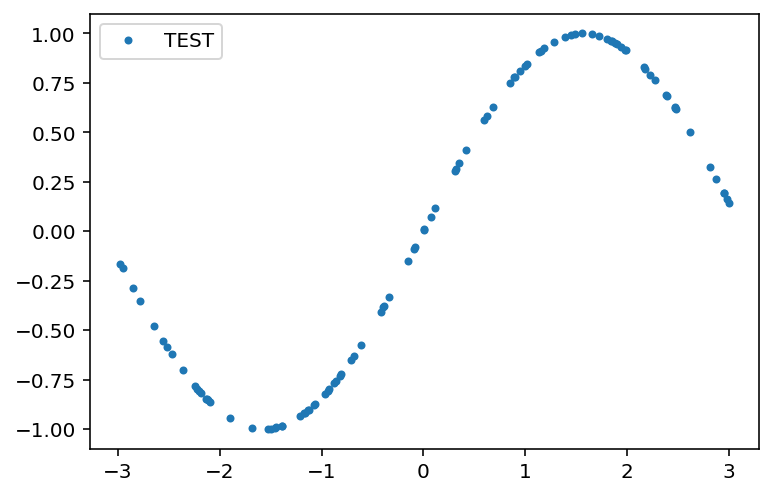

In [70]:
torch.manual_seed(123)
x_train = 6 * torch.rand((1000, 1)) - 3
y_train = torch.sin(x_train)
x_test = 6 * torch.rand((100, 1)) - 3
y_test = torch.sin(x_test)
plt.plot(x_test.numpy(), y_test.numpy(), '.', label='TEST')
plt.legend();

Wrap the tensors into Dataset objects to simplify passing them around:

In [71]:
xy_train = torch.utils.data.TensorDataset(x_train, y_train)
xy_test = torch.utils.data.TensorDataset(x_test, y_test)

Create (and save) the baseline model to use:

In [72]:
torch.manual_seed(123)
baseline = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1),
)
torch.save(baseline.state_dict(), 'baseline.pth')

Now, your job: implement the function below to build a train and test loop using hyperparameters specified as function arguments. Your code should produce a single scatter plot showing the TRAIN and TEST loss curves, similar to the ones we produced earlier.

In [710]:
def learn(train_data, test_data, model, loss_fn=torch.nn.MSELoss(), n_epochs=200,
          batch_size=200, learning_rate=0.1, momentum=0.9, make_plot=True):
    """Perform a train and test loop with specified hyperparameters.
    
    Uses SGD optimization and produces a scatter plot of TRAIN and TEST
    loss versus epoch on a log-linear scale.
    
    Parameters
    ----------
    train_data : torch.utils.data.Dataset
        Container for the training input and target tensors to use.
    test_data : torch.utils.data.Dataset
        Container for the test input and target tensors to use.
    model : torch.nn.Module
        Neural network model of the data whose parameters will be learned.
    loss_fn : callable
        Function of (y_out, y_tgt) that calculates the scalar loss to use.
        Must support backwards() method.
    n_epochs : int
        Number of epochs of training to perform.
    batch_size : int
        Size of each (randomly shuffled) minibatch to use.
    learning_rate : float
        Learning rate to use for the SGD optimizer.
    momentum : float
        Momentum to use for the SGD optimizer.
        
    Returns
    -------
    tuple
        Tuple (train, test) of arrays of loss values after each epoch for
        the TRAIN and TEST samples, respectively. Both lists should have
        length equal to n_epochs.    
    """
    
#     losses_train, losses_test = [], []
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    x_test, y_test = test_data.tensors

    # YOUR CODE HERE...  replace the next line with your solution
    #raise NotImplementedError()
    optimizer = torch.optim.SGD(baseline.parameters(), lr = learning_rate, momentum = momentum)
    torch.manual_seed(123)
    baseline.load_state_dict(torch.load('net.pth'))
    losses_train, losses_test = [], []
    for epoch in range(n_epochs):
        for x_batch, y_batch in loader:
            # Calculate the loss on the training sample.
            baseline.train() # configure the model for training
            y_pred = baseline(x_batch)
            loss = loss_fn(y_pred, y_batch)
            # Update the parameters.
            optimizer.zero_grad()  # reset the gradients
            loss.backward()        # recalculate gradients
            optimizer.step()       # step forward based on gradients
            # Save the training loss after each epoch.
        losses_train.append(loss.data)
            # Calculate and save the test loss after each epoch.
        baseline.eval() # configure the model for evaluation (testing)
        y_pred = baseline(x_test)
        losses_test.append(loss_fn(y_pred, y_test).data)
        if len(losses_test) == 0:
            break
    if make_plot:
        plt.figure(figsize=[6,4])
        plt.plot(losses_train, '.',label=f'B={batch_size},lr={learning_rate:.2f},momentum={momentum:.2f}')
        plt.plot(losses_test, '.', label='TEST')
        plt.legend()
        plt.xlabel('Training Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
    return losses_train, losses_test


Test your code with the default hyperparameters using:

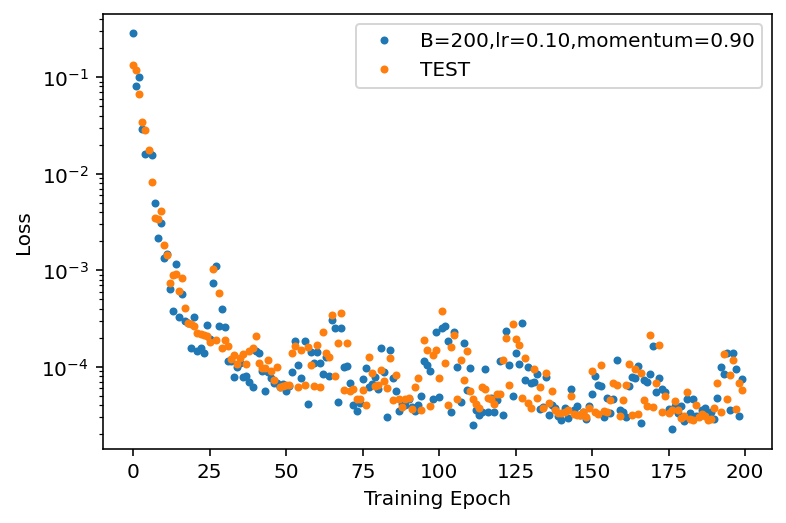

In [84]:
# A correct solution should pass these tests.
torch.manual_seed(123)
baseline.load_state_dict(torch.load('baseline.pth'))
train, test = learn(xy_train, xy_test, baseline)
assert train[0] > 0.1 and test[0] > 0.1
assert train[60] < 1e-3 and test[60] < 1e-3
assert train[-1] < 1e-4 and test[-1] < 1e-4

Run the cell below to establish the same initial state (seed and model parameters) and repeat this learning loop with the optimizer momentum set to zero, to show its effect on the loss curves: large synchronized oscillations in both the TRAIN and TEST data.

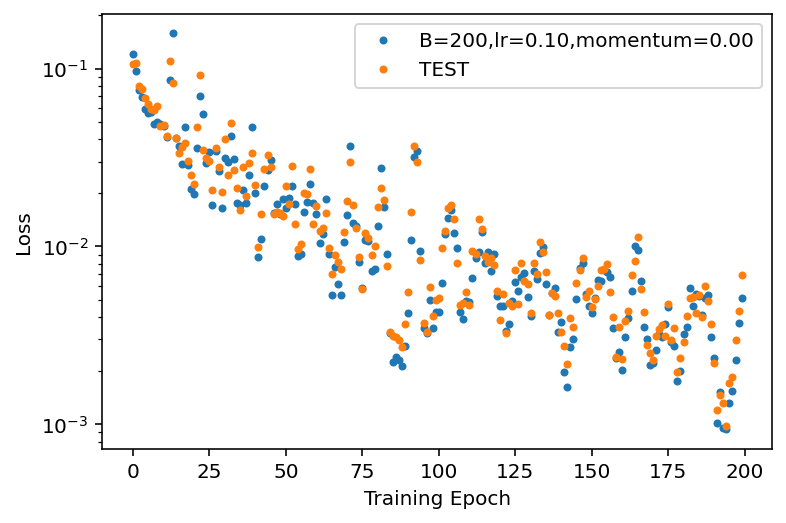

In [85]:
torch.manual_seed(123)
baseline.load_state_dict(torch.load('baseline.pth'))
learn(xy_train, xy_test, baseline, momentum=0);

Now we'll scan different values of the batch size, learning rate, and momentum to find good configurations.  In general it's best to do this by sampling random values of each parameter on any given trial, but for ease of interpretation we'll do it in 1-dimension for a few different sets of configurations.

Make plots showing the loss curves for the training data for each of the following sets of configurations:
* Learning rate = 0.06, batch size=51, for momenta between 0.79 and 1.0 in steps of 0.05
* Momentum=0.9, batch size=51, all values of learning rate
* Learning rate = 0.1, momentum=0.9, all values of batch sizes

Some notes:
* Make sure to reset the random seed and reload the network before each call to the `learn` function!

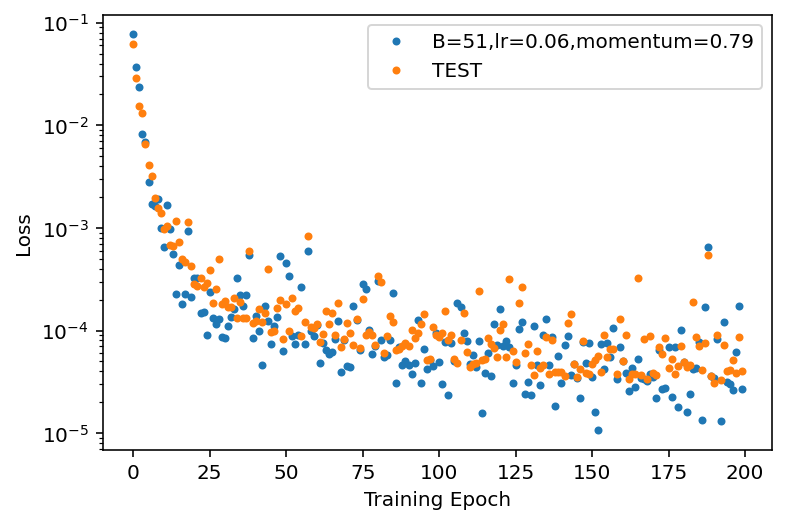

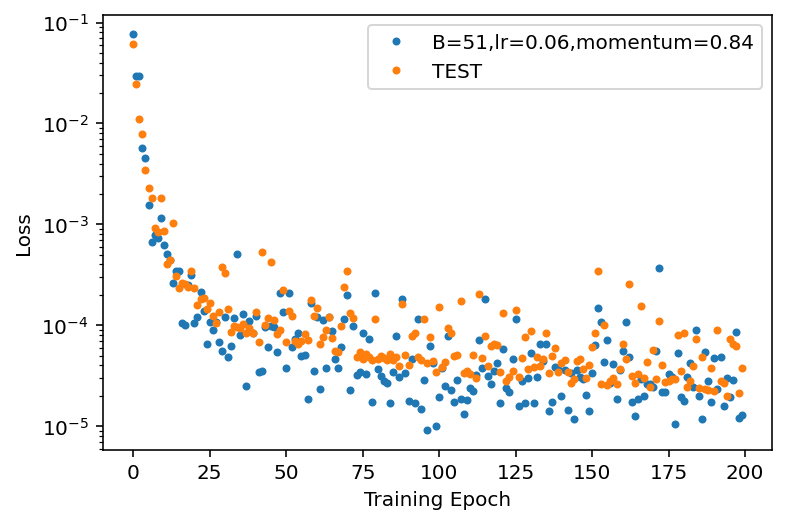

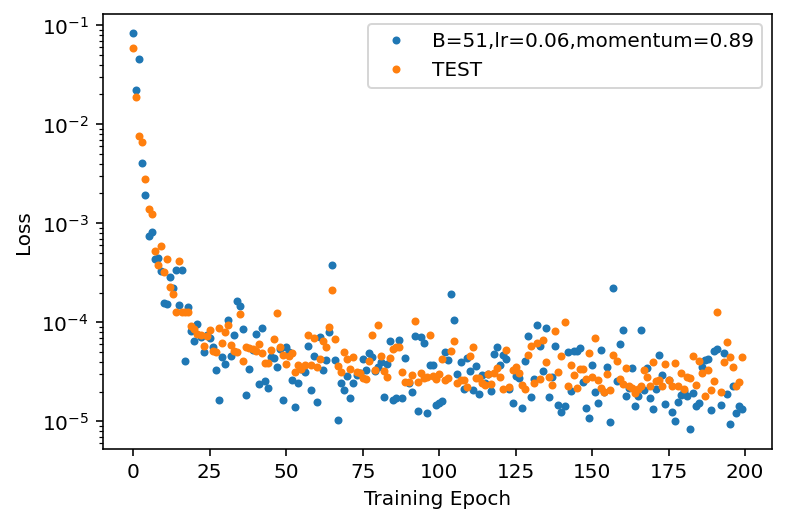

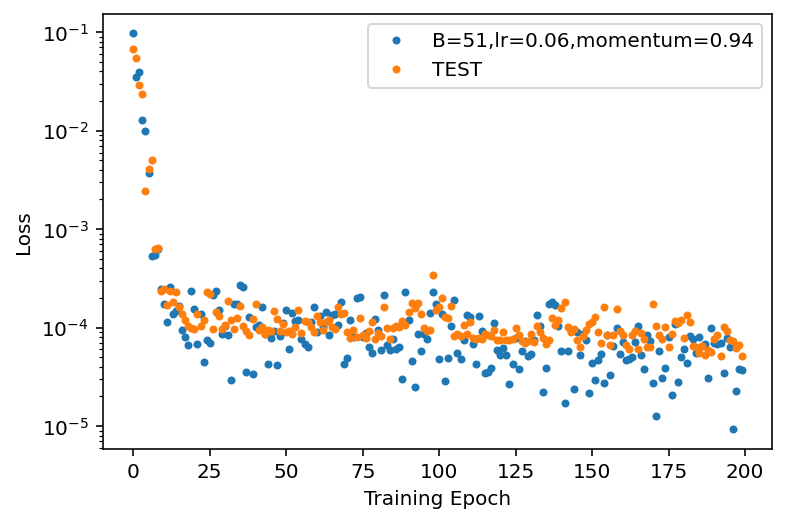

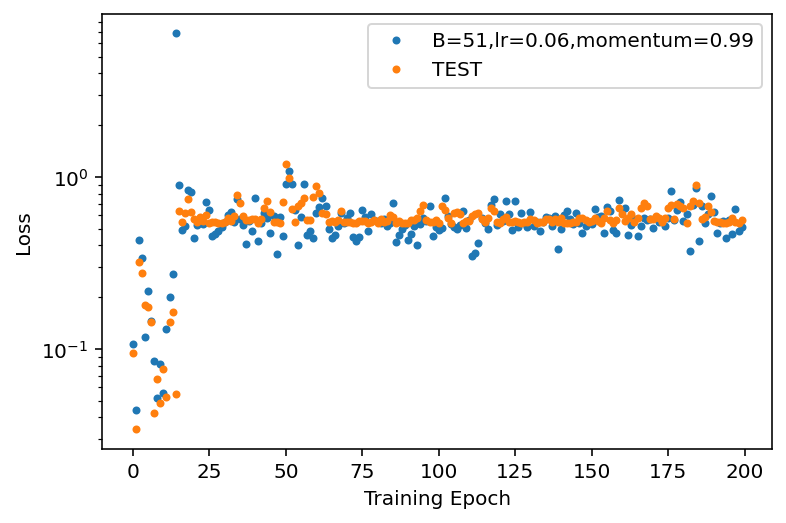

In [86]:
# checking the momentum
#raise NotImplementedError()
'''Learning rate = 0.06, batch size=51, for momenta between 0.79 and 1.0 in steps of 0.05'''
momenta = np.arange(0.79, 1., 0.05)
for momentum in momenta:
    torch.manual_seed(123)
    baseline.load_state_dict(torch.load('baseline.pth'))
    learn(xy_train, xy_test, baseline, batch_size=51, learning_rate=0.06, momentum=momentum);

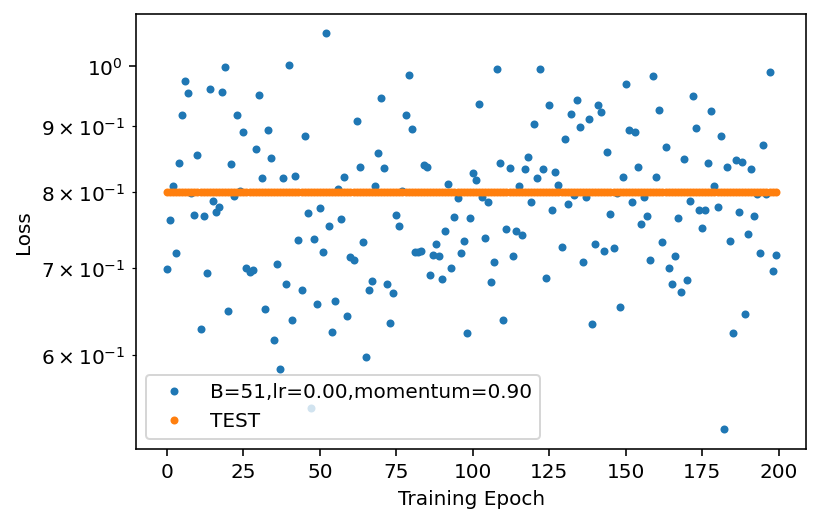

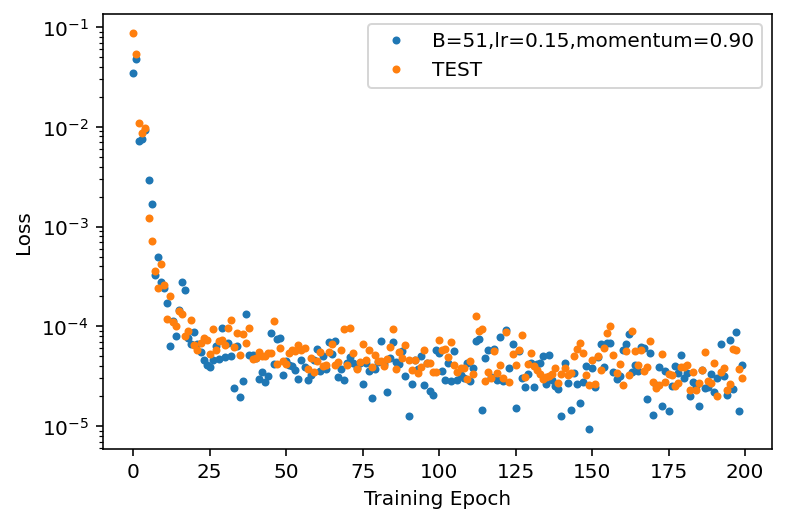

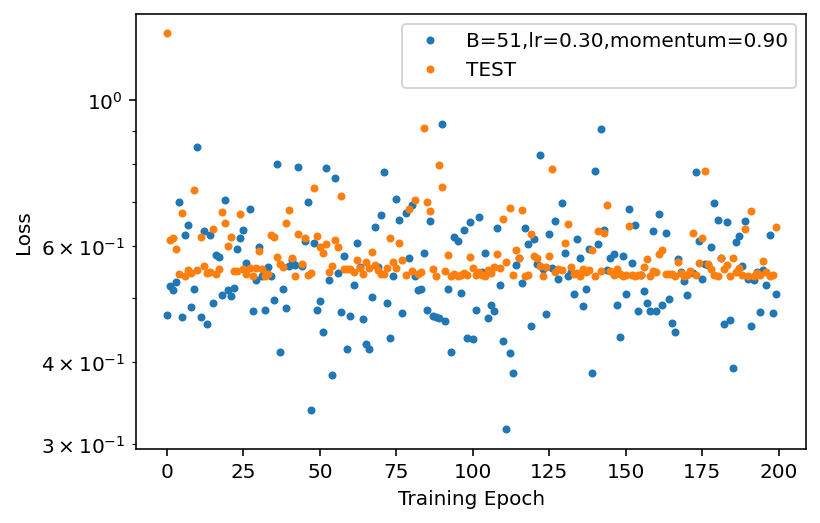

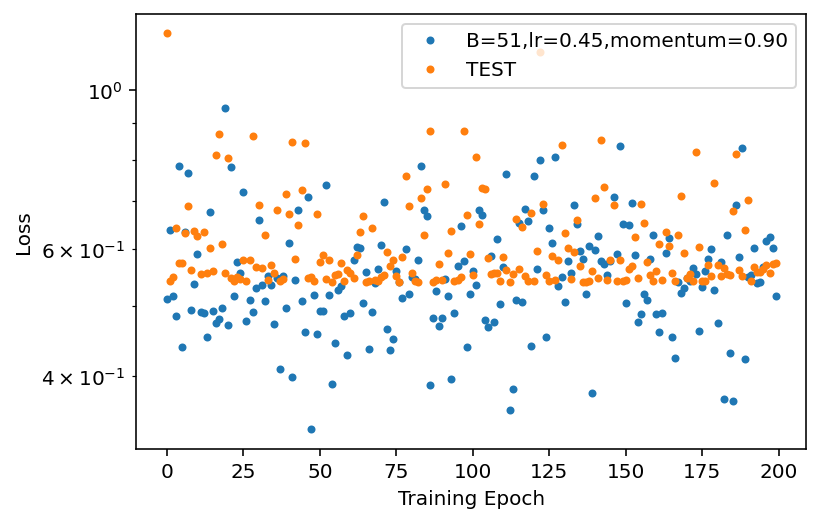

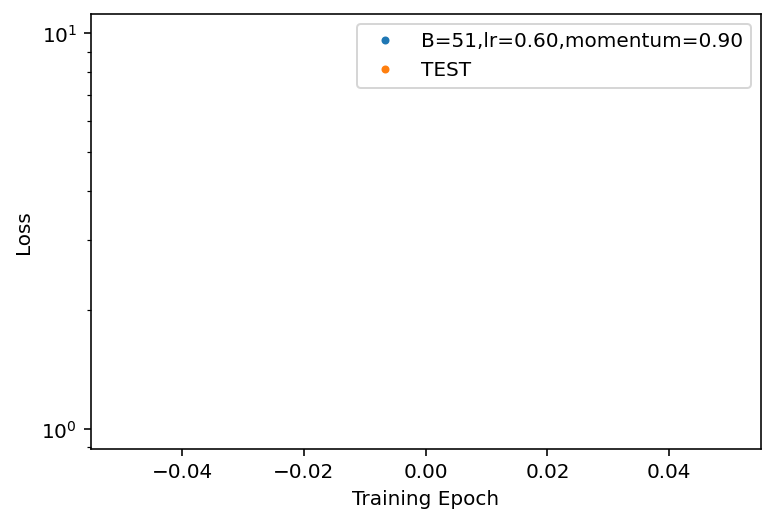

In [712]:
# checking the learning rate
#raise NotImplementedError()
'''Momentum=0.9, batch size=51, all values of learning rate'''
lrs = np.linspace(0., 0.6, 5)
for lr in lrs:
    torch.manual_seed(123)
    baseline.load_state_dict(torch.load('baseline.pth'))
    learn(xy_train, xy_test, baseline, batch_size=51, learning_rate=lr, momentum=0.9)

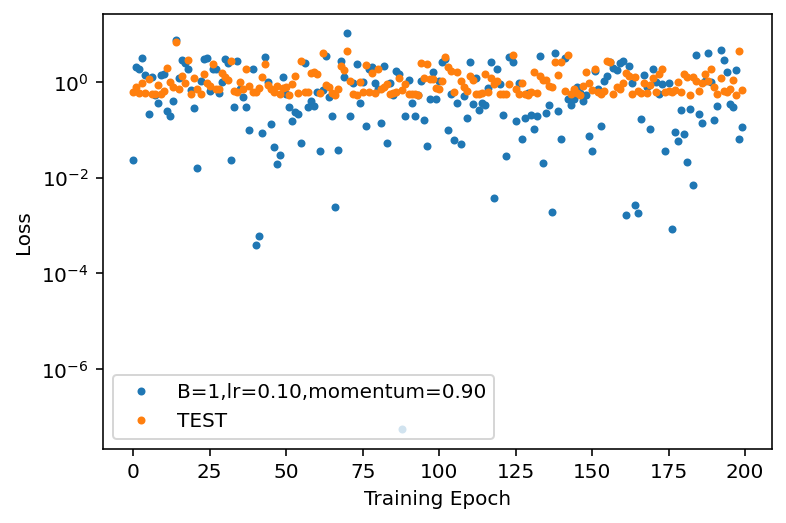

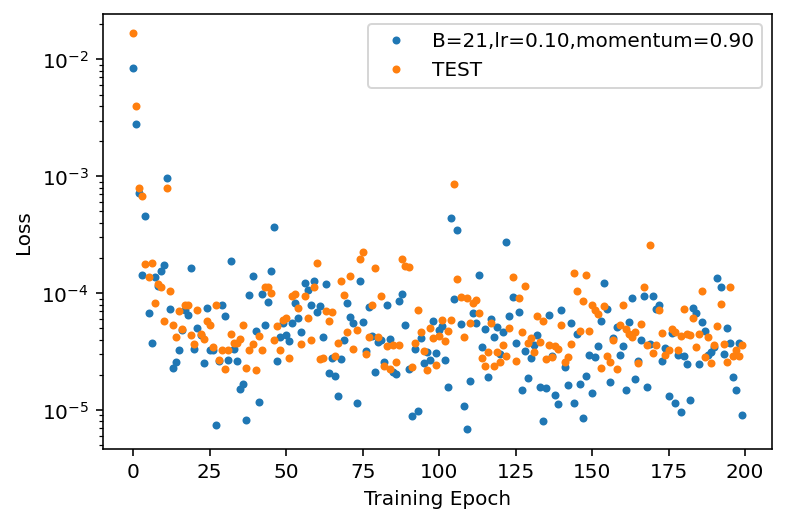

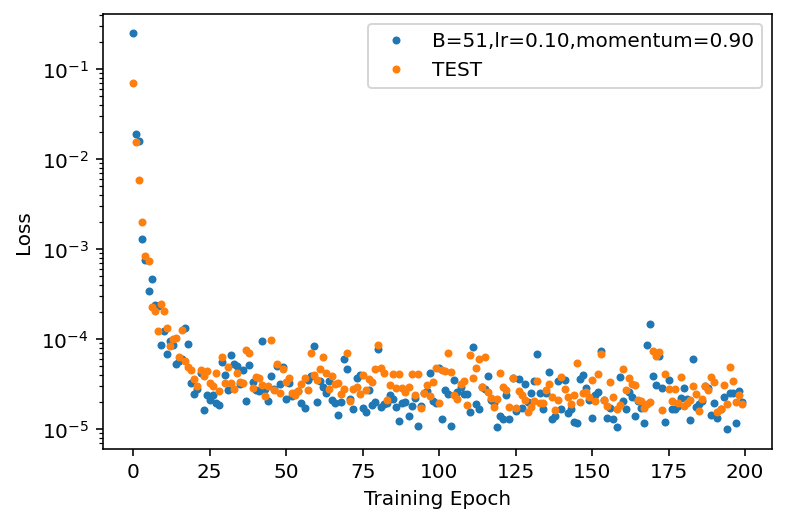

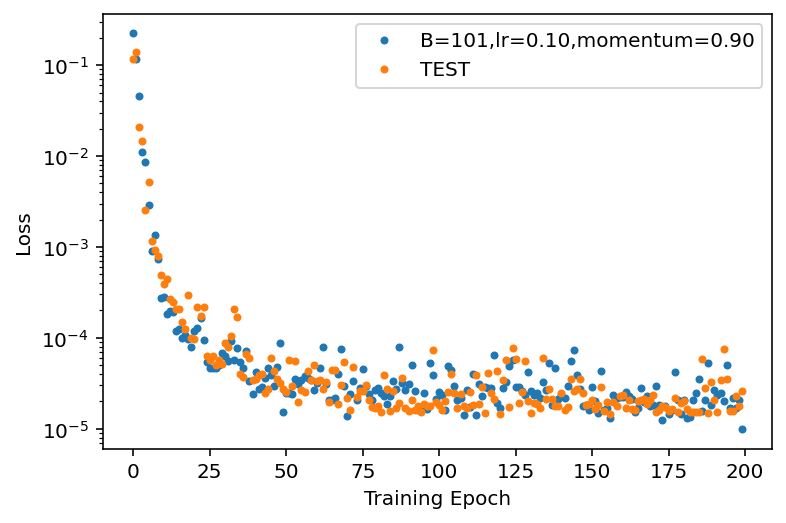

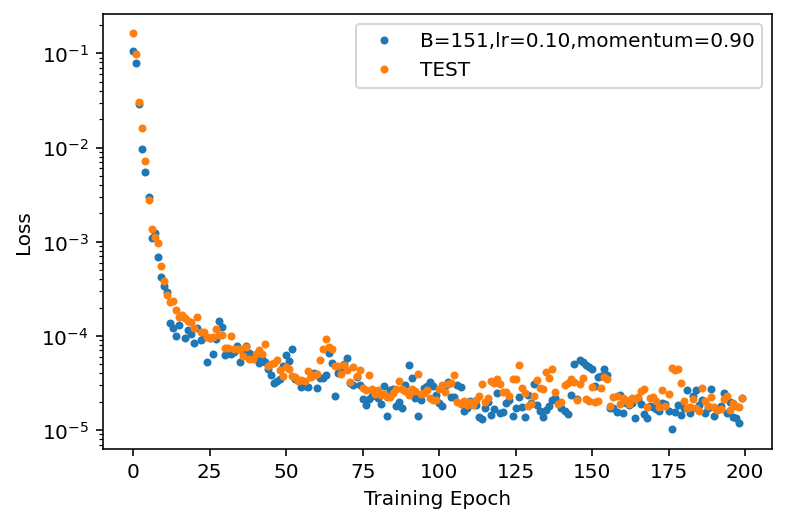

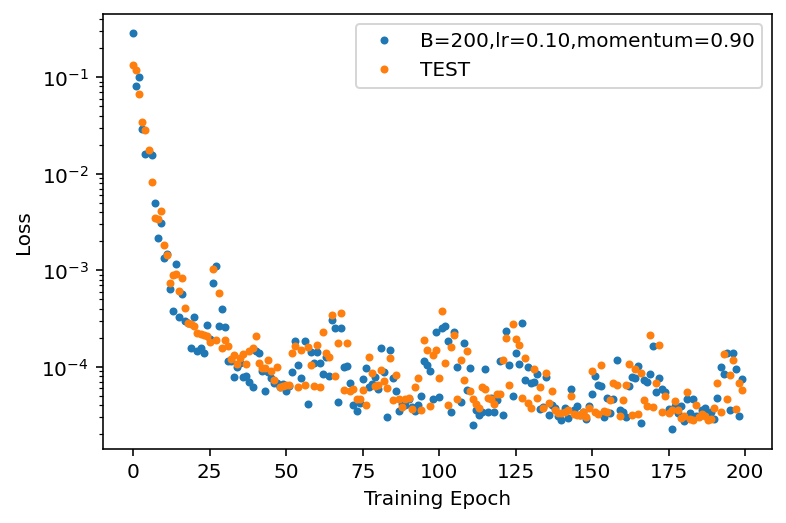

In [99]:
# checking the batch size
'''Learning rate = 0.1, momentum=0.9, all values of batch sizes'''
#raise NotImplementedError()
batch_sizes = [1,21,51,101,151,200]
for size in batch_sizes:
    torch.manual_seed(123)
    baseline.load_state_dict(torch.load('baseline.pth'))
    learn(xy_train, xy_test, baseline, batch_size=size, learning_rate=0.1, momentum=0.9);

## Problem 2

Let's play around with convolutional kernels and see if we can make some simple filters to apply to real images.  We'll use the `torchvision` package to transform common image formats:

In [100]:
from PIL import Image
import torchvision

The pytorch `Conv2D` function that we used to implement some convolutional layers is a high-level function call, and manages the kernel weights internally.

In [101]:
# With square kernels and equal stride
m = torch.nn.Conv2d(16, 33, 3, stride=2)

# non-square kernels and unequal stride and with padding
m = torch.nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))

# non-square kernels and unequal stride and with padding and dilation
m = torch.nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))

# generate some random input:
input = torch.randn(20, 16, 50, 100)

# compute the output:
output = m(input)

We can use the lower-level function `torch.nn.functional.conv2d` to manipulate kernels and tensors directly.  

Let's do something simple: let's define a 1-layer 5x5 matrix and convolve it with a 3x3 kernel to produce a 3x3 output feature map.  We'll make the kernel super-simple, the equivalent of an identity matrix for convolutions.

In [130]:
channels = 1
h, w = 5, 5
x = torch.randn(1, channels, h, w)
print(x)
weights = torch.tensor([[0., 0., 0.],
                        [0., 1., 0.],
                        [0., 0., 0.]])
weights = weights.view(1, 1, 3, 3)

output = torch.nn.functional.conv2d(x, weights)
print(output)

tensor([[[[-0.8363, -0.9633, -1.5035,  1.8623, -0.3980],
          [ 0.6568, -0.5563,  0.5114,  1.5047, -0.8578],
          [-1.8839,  1.4466, -1.2043,  0.9338,  0.7754],
          [-0.0486, -1.0902,  1.0583,  1.4793, -0.8514],
          [ 1.6615,  0.2934,  0.1753, -0.5089, -0.0328]]]])
tensor([[[[-0.5563,  0.5114,  1.5047],
          [ 1.4466, -1.2043,  0.9338],
          [-1.0902,  1.0583,  1.4793]]]])


If we add in some padding, then we can make the output tensor the same size as the input:

In [131]:
output = torch.nn.functional.conv2d(x, weights,padding=1)
print(output)

tensor([[[[-0.8363, -0.9633, -1.5035,  1.8623, -0.3980],
          [ 0.6568, -0.5563,  0.5114,  1.5047, -0.8578],
          [-1.8839,  1.4466, -1.2043,  0.9338,  0.7754],
          [-0.0486, -1.0902,  1.0583,  1.4793, -0.8514],
          [ 1.6615,  0.2934,  0.1753, -0.5089, -0.0328]]]])


Of course it's possible to do this for more than just one channel, but that gets a bit tricky, so I'll leave that for you to play with if you want!

For now let's just try to do something simple with a one-channel image:

In [104]:
import urllib.request
urllib.request.urlretrieve("http://mhance.scipp.ucsc.edu/banana-slug-misty-morehead.jpg", "banana_slug.jpg")

('banana_slug.jpg', <http.client.HTTPMessage at 0x7f9018f99ee0>)

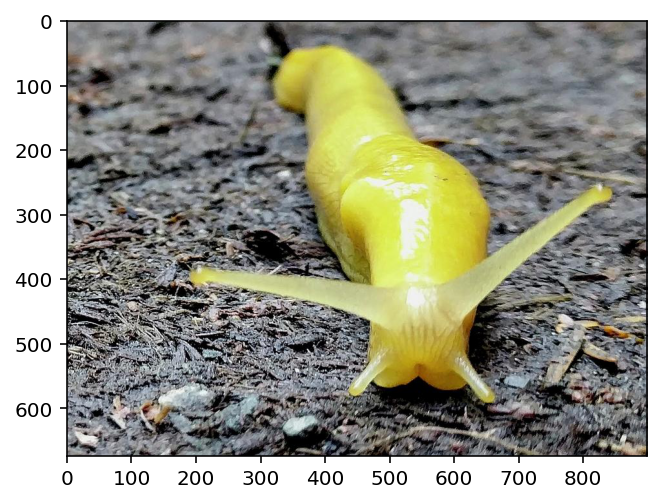

In [105]:
img = Image.open("banana_slug.jpg")
plt.imshow(img)

We can turn this into a numpy array relatively easily:

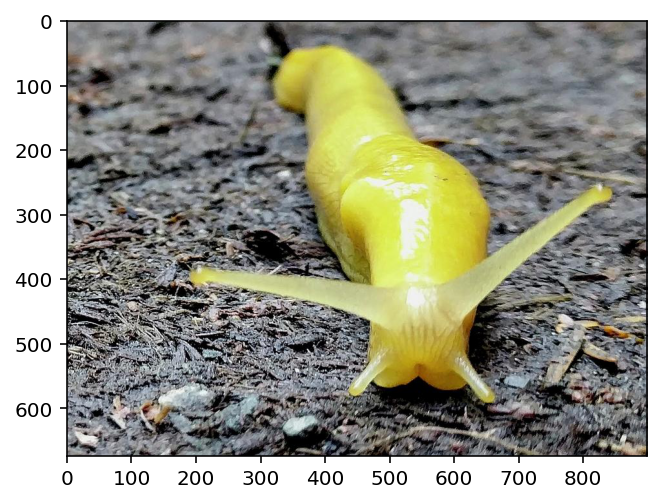

In [106]:
npimg=np.asarray(img)
plt.imshow(npimg)

Or we can use `torchvision` to turn it into a pytorch tensor, and then check that the tensor gives us back the image:

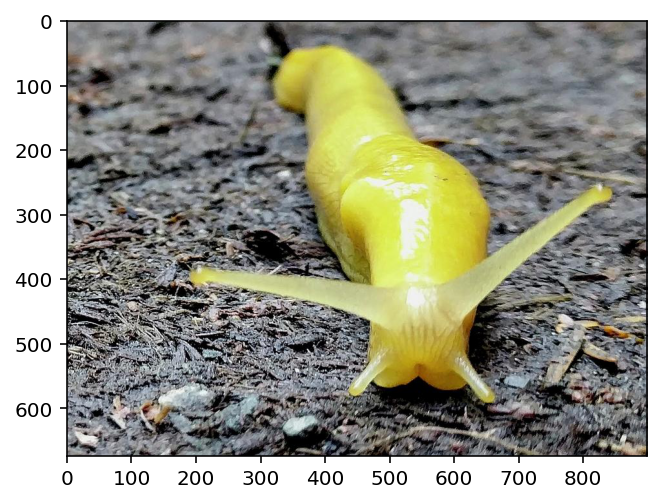

In [107]:
imgtensor=torchvision.io.read_image("banana_slug.jpg")
plt.imshow(torchvision.transforms.functional.to_pil_image(imgtensor))

Let's make this a grayscale image so we only need to deal with a single channel:

In [397]:
grayscaleimage=torchvision.transforms.Grayscale()(img)
grayscaleimage.show()

Note that if we try to show this image using `plt.imshow` it will try to color it in for us:

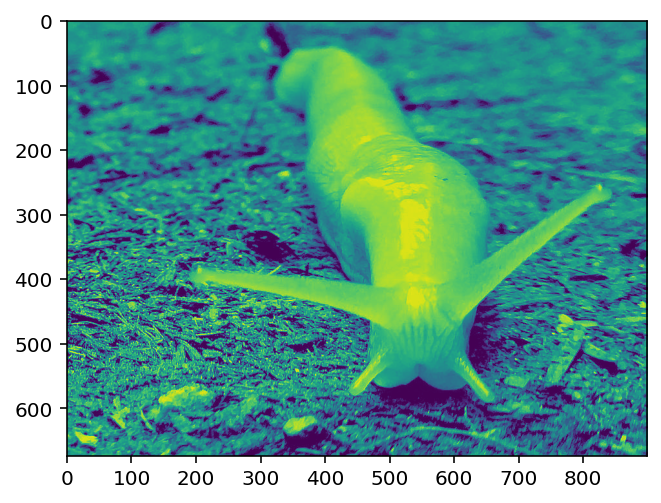

In [398]:
plt.imshow(grayscaleimage)

So force it into grayscale:

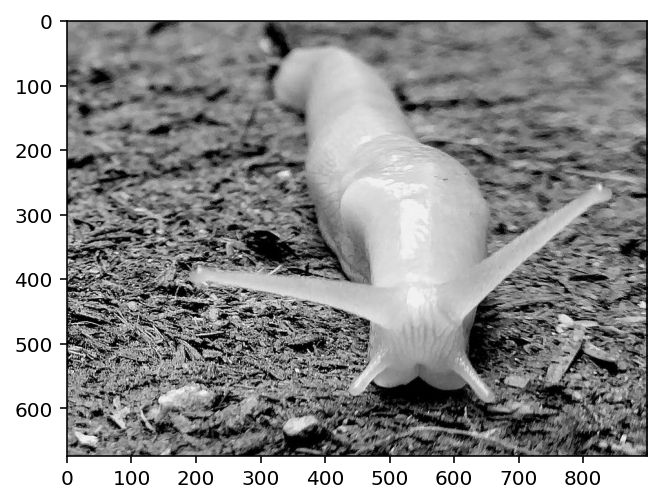

In [399]:
plt.imshow(grayscaleimage,cmap='gray')

We can make this into a tensor for processing:

In [400]:
grayscaleimagetensor=torchvision.transforms.functional.to_tensor(grayscaleimage)

Now, your job: 
* implement a 3x3 kernel that shifts every pixel one step to the right
* take the difference between the resulting feature map and the original image
* display the resulting image

In [401]:
# Your code here
#raise NotImplementedError()

Text(0.5, 1.0, 'difference b/w input image & feature map')

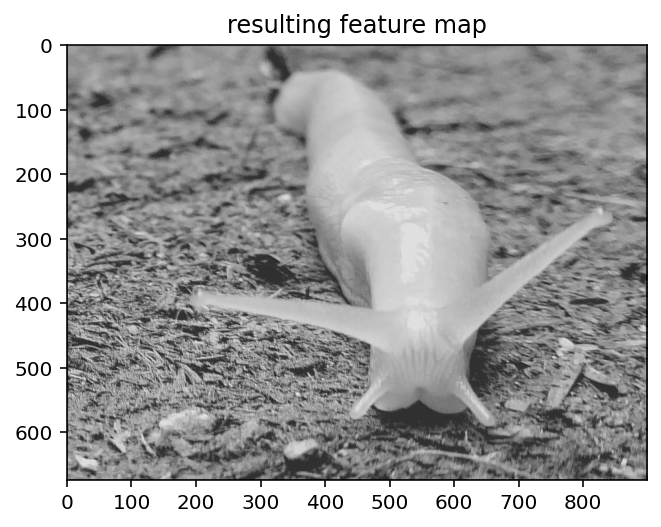

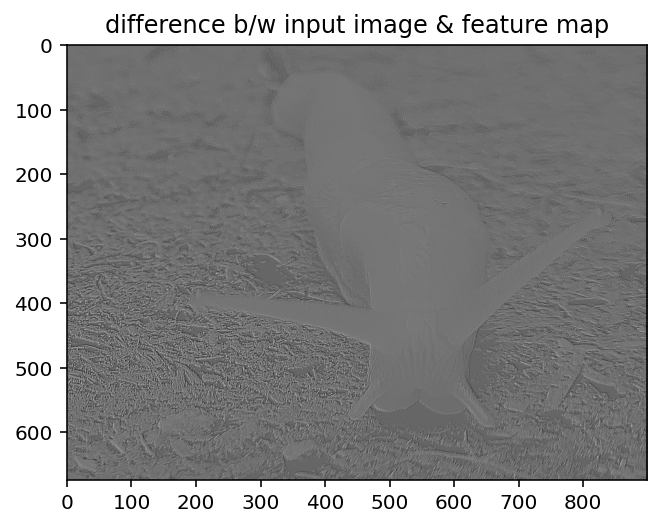

In [430]:
m = torch.nn.Conv2d(1, 1, 3, stride=1, padding=1)
'''
The size of the feature map is different from the input image, so I need to add padding=1 so that I can 
    take the difference between the resulting feature map and the original image
'''

'''
Another way to do this is to cut the input image so that it matches shape as the feature map
    i.e. imgin = imgin[0,:-2,:-2] (cut the first two column & rows of pixels)
      or imgin = imgin[0,2:,2:] (cut the last two column & rows of pixels)
'''
mout = m(grayscaleimagetensor)
mout = mout.detach().numpy()
imgin = grayscaleimagetensor.detach().numpy()

plt.figure(figsize=[6,4])
plt.imshow(mout[0,:,:],cmap='gray')
plt.title('resulting feature map')
plt.figure(figsize=[6,4])
#plt.imshow(imgin[0,:-2,:-2] - mout[0,:,:],cmap='gray')
plt.imshow(imgin[0,:,:] - mout[0,:,:],cmap='gray')
plt.title('difference b/w input image & feature map')

### The feature map looks different everytime I run the cell above. My guess is that the elements in the 3x3 kernel is generated randomly. Just to make sure, I tried differenta weights of 3x3 kernal myself to see the difference.

In [362]:
'''
Try different weights for the 3x3 kernel. The output feature map looks 
different when I play around w/ different weights, which is fun!!
'''
weights = torch.tensor([[0, 0., 0],
                        [0, 100., 0.],
                        [-100., 0., 0.]])

# weights = torch.tensor([[100, 100., 100.],
#                         [100, -100., 100.],
#                         [100.,100., 100.]])

weights = weights.view(1, 1, 3, 3)

output = torch.nn.functional.conv2d(grayscaleimagetensor,weights,padding=1)
print(output)

tensor([[[ 57.2549,  -2.7451,  -2.7451,  ...,   0.3922,   0.3922,   0.3922],
         [ 60.0000,   0.3922,   0.7843,  ...,  -0.3922,  -0.3922,  -0.3922],
         [ 60.0000,   1.5686,   1.5686,  ...,  -0.7843,  -0.7843,  -0.3922],
         ...,
         [ 59.2157,  -1.5686, -11.3726,  ...,  -7.8431, -11.7647, -15.6863],
         [ 58.8235,  -0.7843,  -5.0980,  ..., -16.8627, -15.2941, -17.2549],
         [ 58.4314,  59.6078,  60.0000,  ...,  33.7255,  38.8235,  42.3529]]])


In [363]:
outimg = np.array(output)[0,:,:]
inimg = np.array(grayscaleimagetensor[0,:,:])

In [364]:
outimg.shape

(674, 900)

Text(0.5, 1.0, 'difference b/w input image & feature map')

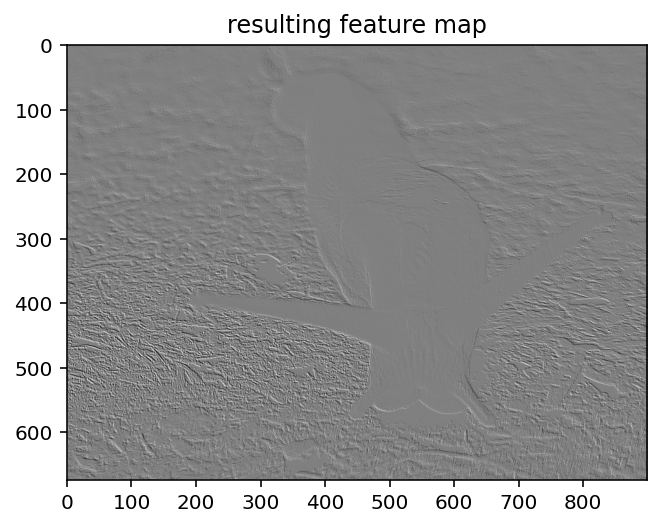

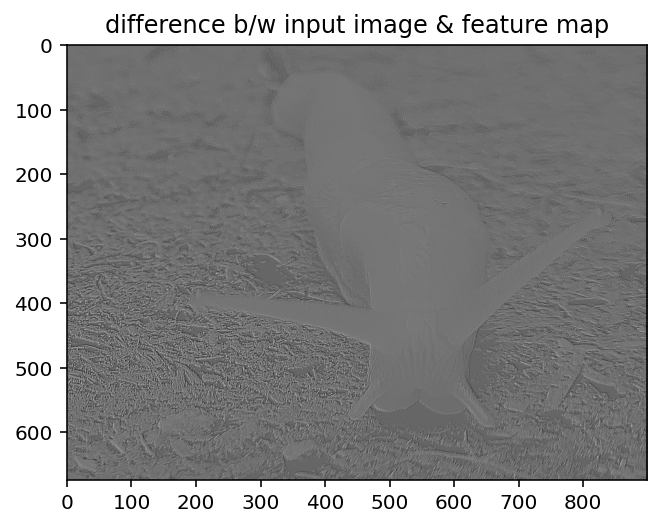

In [459]:
plt.figure(figsize=[6,4])
plt.imshow(outimg,cmap='gray')
plt.title('resulting feature map')
plt.figure(figsize=[6,4])
plt.imshow(imgin[0,:,:] - mout[0,:,:],cmap='gray')
plt.title('difference b/w input image & feature map')

### I made a kernel that only detects the sharp edges in the images. To see it more clearly, I plot the image in log scale and inverted it. Now the shape of the banana slug looks clearer than the origional image. I guess this can be an input for fully-connected networks for image recognition. Cute!

/var/folders/br/6sw3kv492t7c0z79vwnhb9gr0000gn/T/ipykernel_54982/335921367.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(-np.log(outimg+15),cmap='gray')


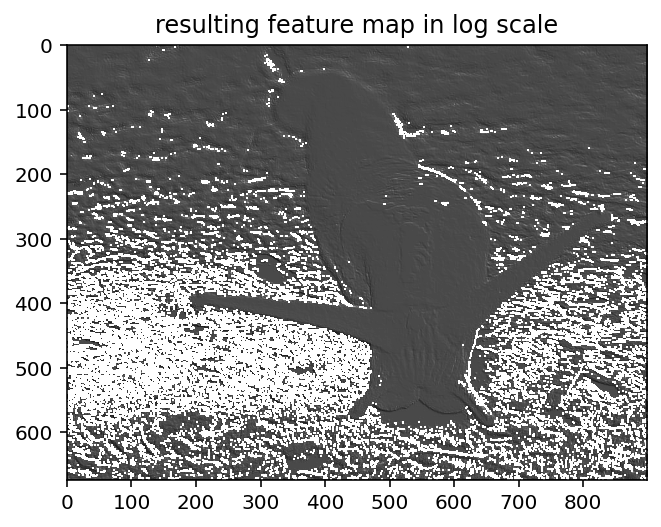

In [458]:
plt.imshow(-np.log(outimg+15),cmap='gray')
plt.title('resulting feature map in log scale');

## Problem 3

This is the problem where you should explore the input dataset that you'll use for your final project.

I'll do this for a mock dataset, but you should go through a similar exercise with your dataset.

I'm importing data that's been stored in the HDF5 format, using the [h5py](https://docs.h5py.org/en/stable/) python package:

In [345]:
import h5py

If your data are stored in a different format, then certainly some of the details below will have to change, that's OK!  There are lots of ways to read in CSV files and more complicated file formats into python data structures.

If you're using ROOT files (common in high-energy physics), there are also lots of ways to get information from those files into python lists.  If you want to convert a ROOT file into HDF5, you can use [this script](https://github.com/scipp-atlas/mario-mapyde/blob/main/scripts/root2hdf5.py).

In [346]:
signalfile='lowlevelAna_stops.hf5'
urllib.request.urlretrieve("http://mhance.scipp.ucsc.edu/%s" % signalfile, signalfile)

backgrfile='lowlevelAna_ttbar.hf5'
urllib.request.urlretrieve("http://mhance.scipp.ucsc.edu/%s" % backgrfile, backgrfile)

('lowlevelAna_ttbar.hf5', <http.client.HTTPMessage at 0x7f901bc62f40>)

Let's inspect the contents of the HDF5 file just to get a sense for what's there:

In [347]:
with h5py.File(signalfile, 'r') as hdf5file:
    print("Here are the keys in this file")
    print(hdf5file.keys())
    print("\n")
    
    # let's access the first key by its index:
    group=hdf5file[list(hdf5file.keys())[0]]
    print("What type does this key have?")
    print(type(group))
    print("It's a group, so we'll need to look inside of the group to find the dataset")
    print(group.keys())
    data=group["lowleveltree"]
    print("\n")
    
    print("These are the fields (features) of the dataset:")
    print(data.dtype.names)
    print("\n")
    
    print("Here are the contents of the first event:")
    print(data[0])
    print("\n")
    
    print("This is the number of jets (numjet) in all events: ")
    print(data["numjet"])
    print("\n")

Here are the keys in this file
<KeysViewHDF5 ['allev']>


What type does this key have?
<class 'h5py._hl.group.Group'>
It's a group, so we'll need to look inside of the group to find the dataset
<KeysViewHDF5 ['lowleveltree']>


These are the fields (features) of the dataset:
('numlepton', 'numjet', 'numbtagjet', 'met', 'metphi', 'weight', 'lepton1pT', 'lepton1eta', 'lepton1phi', 'lepton1mT', 'lepton1minjetdr', 'lepton2pT', 'lepton2eta', 'lepton2phi', 'lepton2mT', 'lepton2minjetdr', 'lepton3pT', 'lepton3eta', 'lepton3phi', 'lepton3mT', 'lepton3minjetdr', 'jet1pT', 'jet1eta', 'jet1phi', 'jet1b', 'jet2pT', 'jet2eta', 'jet2phi', 'jet2b', 'jet3pT', 'jet3eta', 'jet3phi', 'jet3b', 'jet4pT', 'jet4eta', 'jet4phi', 'jet4b', 'jet5pT', 'jet5eta', 'jet5phi', 'jet5b', 'jet6pT', 'jet6eta', 'jet6phi', 'jet6b', 'jet7pT', 'jet7eta', 'jet7phi', 'jet7b', 'jet8pT', 'jet8eta', 'jet8phi', 'jet8b', 'jet9pT', 'jet9eta', 'jet9phi', 'jet9b', 'jet10pT', 'jet10eta', 'jet10phi', 'jet10b', 'jet11pT', 'jet11eta', 'j

Now that we know the format, accessing the data is a bit easier...  let's restrict the list of fields (I'll call them 'branches') we read in:

In [348]:
branches=("numjet","numlepton","numbtagjet",
          "met","metphi",
          "lepton1pT","lepton1eta","lepton1phi",
          "lepton2pT","lepton2eta","lepton2phi",
          "jet1pT", "jet1eta", "jet1phi","jet1b",
          "jet2pT", "jet2eta", "jet2phi","jet2b",
          "jet3pT", "jet3eta", "jet3phi","jet3b",
          "jet4pT", "jet4eta", "jet4phi","jet4b",
          "jet5pT", "jet5eta", "jet5phi","jet5b",
          "jet6pT", "jet6eta", "jet6phi","jet6b")

with h5py.File(signalfile, 'r') as hdf5file:
    data=hdf5file[list(hdf5file.keys())[0]]["lowleveltree"]
    num_signal_events=len(data["numjet"])
    alldata=data[branches]

with h5py.File(backgrfile,'r') as hdf5file:
    data=hdf5file[list(hdf5file.keys())[0]]["lowleveltree"]
    num_backgr_events=len(data["numjet"])
    alldata = np.concatenate((alldata,data[branches]))

We read in the data as fields with a custom format, which is useful for keeping track of what's what, but 
let's store this as python lists instead

In [349]:
Alldata=[[float(i) for i in j] for j in alldata]
print(Alldata[0])

[3.0, 1.0, 1.0, 288.4065856933594, -0.06142895296216011, -3.113394260406494, 0.0, 0.0, -9.0, 0.0, 0.0, 197.14732360839844, 1.1485222578048706, -2.092724561691284, 0.0, 185.49407958984375, 0.19658531248569489, 2.4949371814727783, 1.0, 108.71955108642578, 1.519853949546814, 0.9874062538146973, 0.0, -999.0, -9.0, -9.0, -9.0, -999.0, -9.0, -9.0, -9.0, -999.0, -9.0, -9.0, -9.0]


The `Alldata` variable now contains all of the data for both signal and background events.  Since this will be for a binary classification problem, we want to keep track of which event is which, so we'll construct a `y` list that has 0's and 1's corresponding to whether each event is background (0) or signal (1).

In [350]:
y = np.concatenate((np.ones (num_signal_events), 
                    np.zeros(num_backgr_events)))

Now we can split our full dataset into training and test samples.  However, remember that the data aren't randomized...  the first N events of `Alldata` are all signal events, and the rest of the events are background events.  So we need to shuffle the data first, then pull out training and test samples of a specific size.  The `scikit learn` toolkit has a handy function that does this for us:

In [351]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(Alldata, y, test_size=1000, random_state=123)

We can look at the input features for our training dataset.  First let's make a map of the feature name to the feature data:

In [352]:
X_train_before_scaling={}
for b in branches:
    X_train_before_scaling[b]=[event[branches.index(b)] for event in X_train]

Now plot the data for each feature

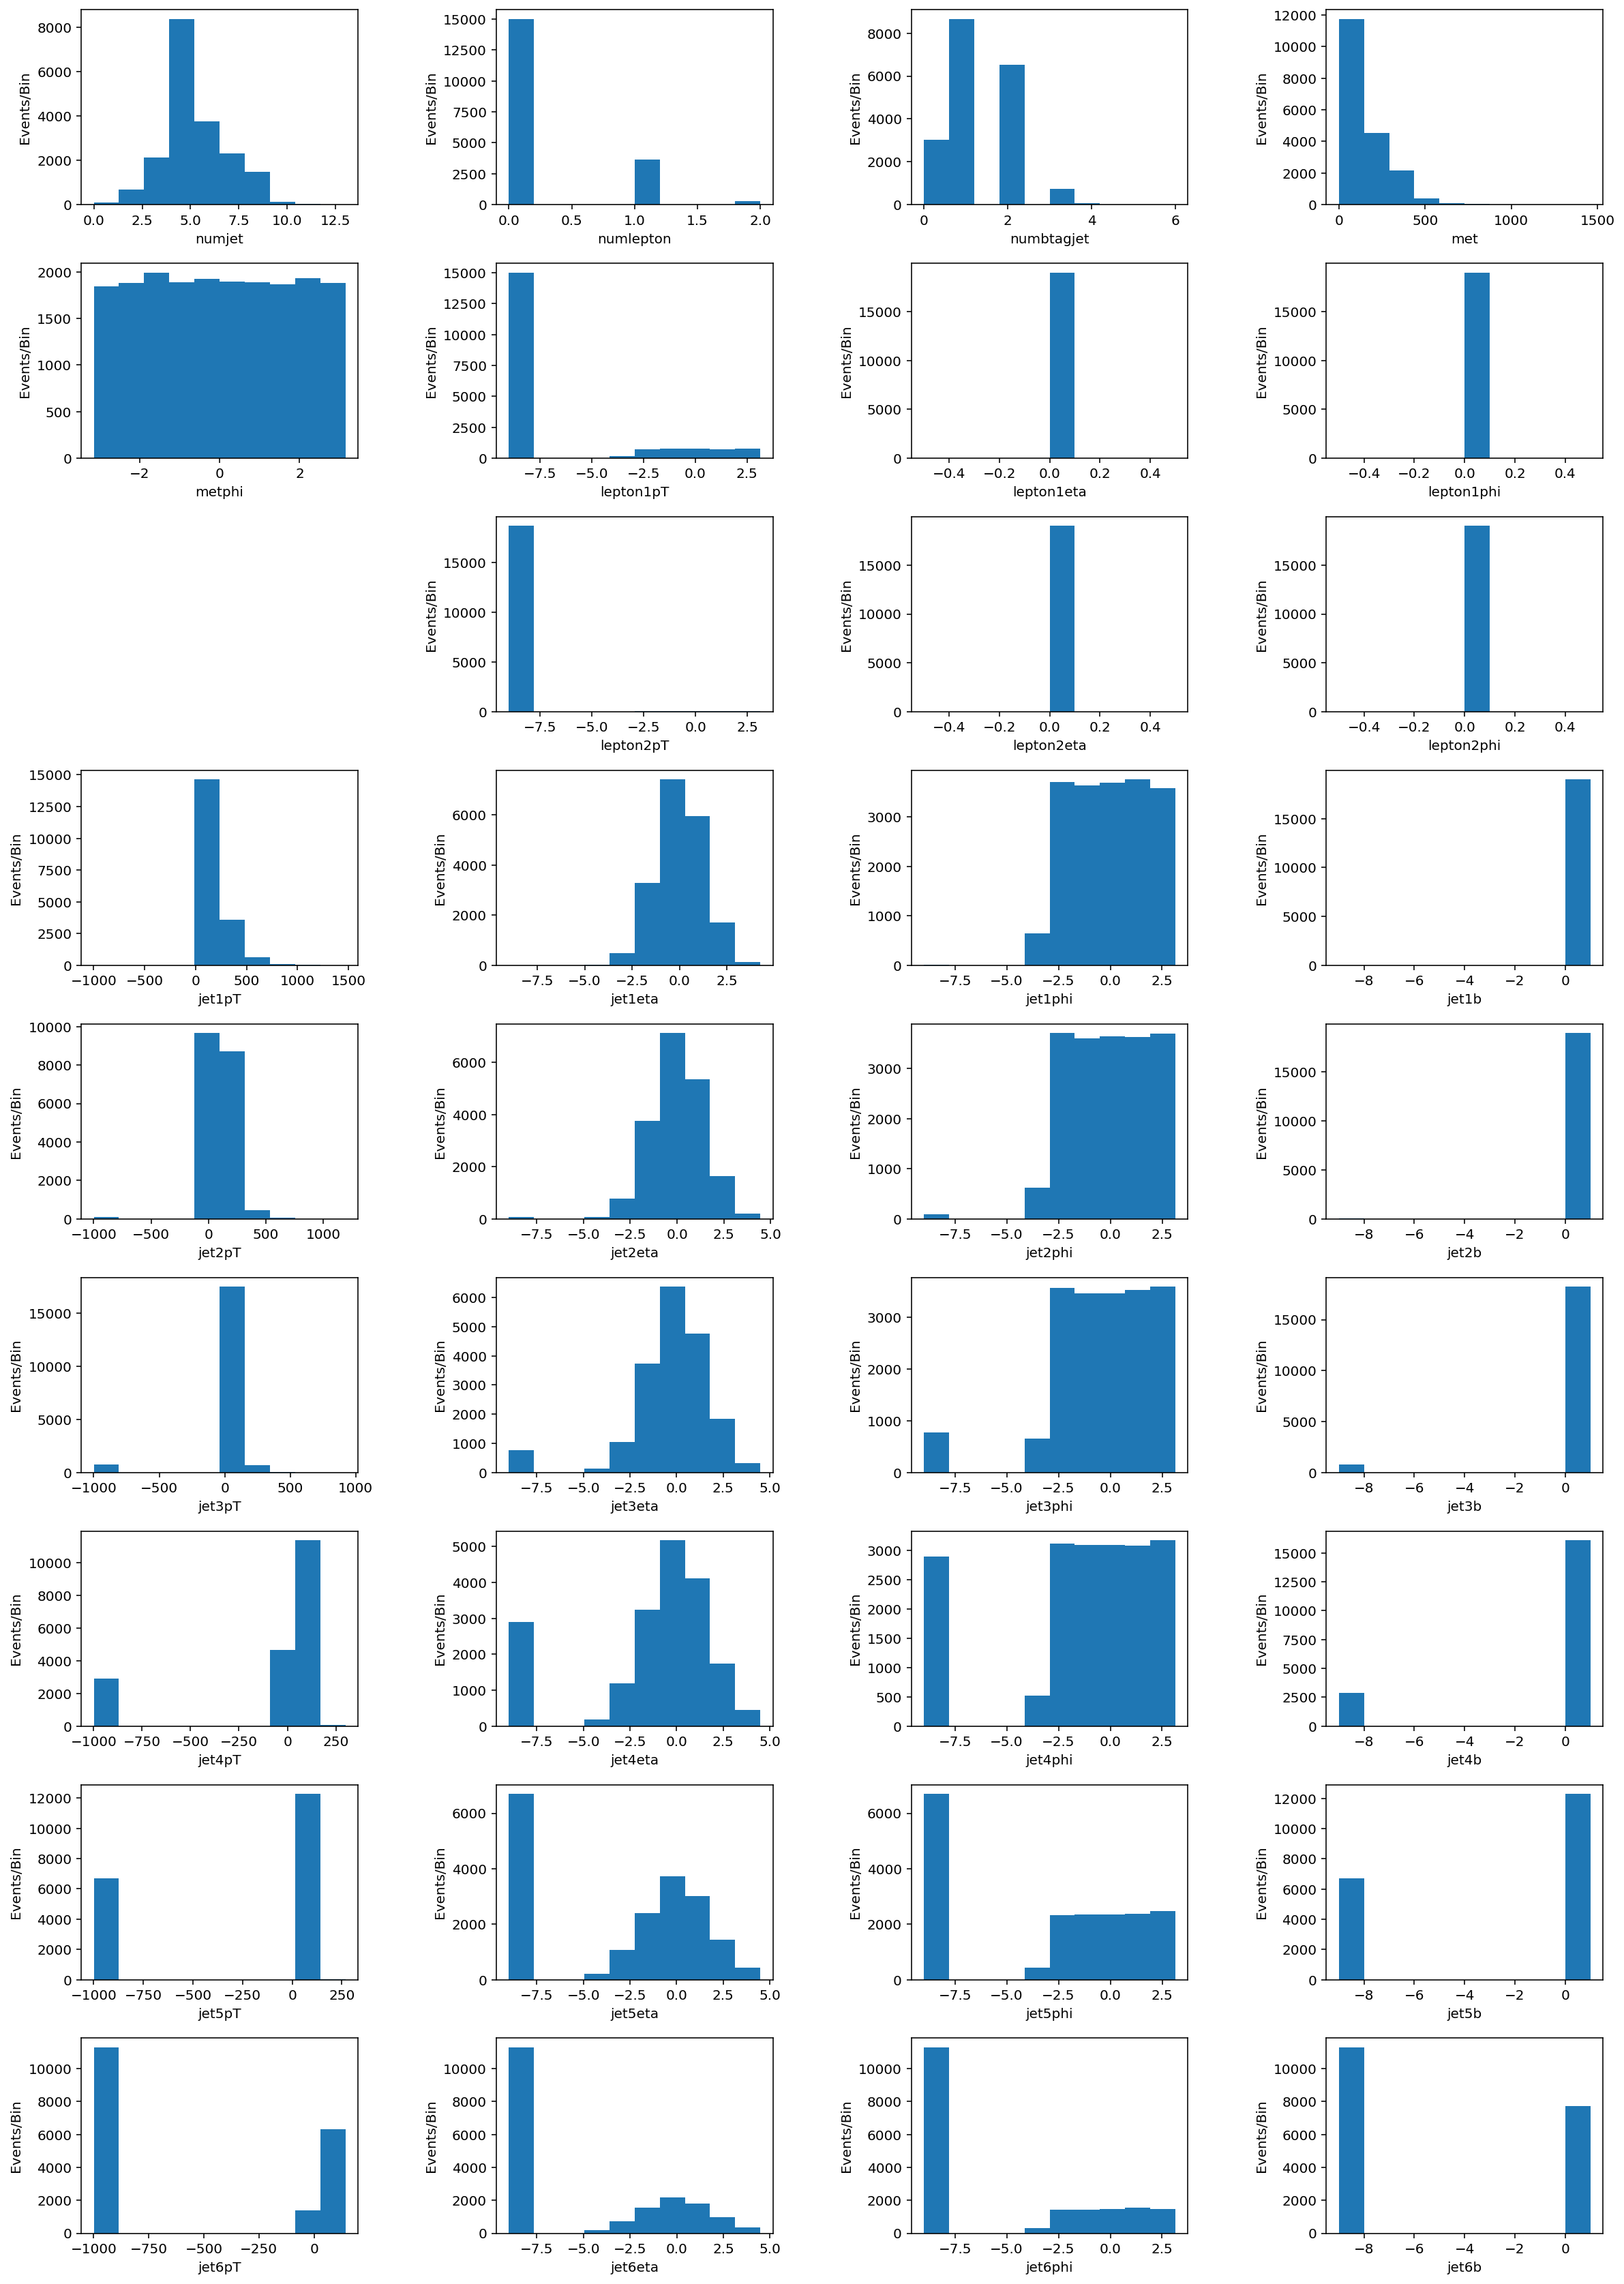

In [353]:
fig = plt.figure(figsize=(20,30))
fig.tight_layout()
for b in range(len(branches)):
    ax=fig.add_subplot(9,4,1+b if b<8 else 2+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    ax.hist(X_train_before_scaling[branches[b]])
    ax.set_xlabel(branches[b])
    ax.set_ylabel("Events/Bin")

This looks good, but the inputs are all over the place!  Some are strictly positive, some have values in the 1's or 10's while others have values in the 1000's.  This broad range of inputs will likely confuse our network and cause some features to have inappropriate influence on the results.  So we should scale the events for each feature to give a distribution that has mean=0 and variance=1.  We can do this for each feature with the following mapping:

$$x \rightarrow z=\frac{x-\mu}{\sigma}$$

where $x$ is the original value, $z$ is the 'scaled' value, $\mu$ is the mean of all values of $x$, and $\sigma$ is the standard deviation of $x$.  This isn't hard to do by hand, but again `scikit learn` provides a handy way to do this:

In [354]:
# now scale based on the training data:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

Let's make that handy map for the scaled data so we can look at the data by feature:

In [355]:
X_train_after_scaling={}
for b in branches:
    X_train_after_scaling[b]=[event[branches.index(b)] for event in X_train]

Print some values just to see what happens to a typical variable:

In [356]:
print(X_train_before_scaling["met"][:5])
print(X_train_after_scaling["met"][:5])

[147.20162963867188, 257.41204833984375, 277.15020751953125, 249.11927795410156, 182.775634765625]
[0.042741974149220964, 0.893269863692495, 1.0455953431563554, 0.829271989645971, 0.31727757486468516]


Now re-draw the features after they've been scaled to see what they look like:

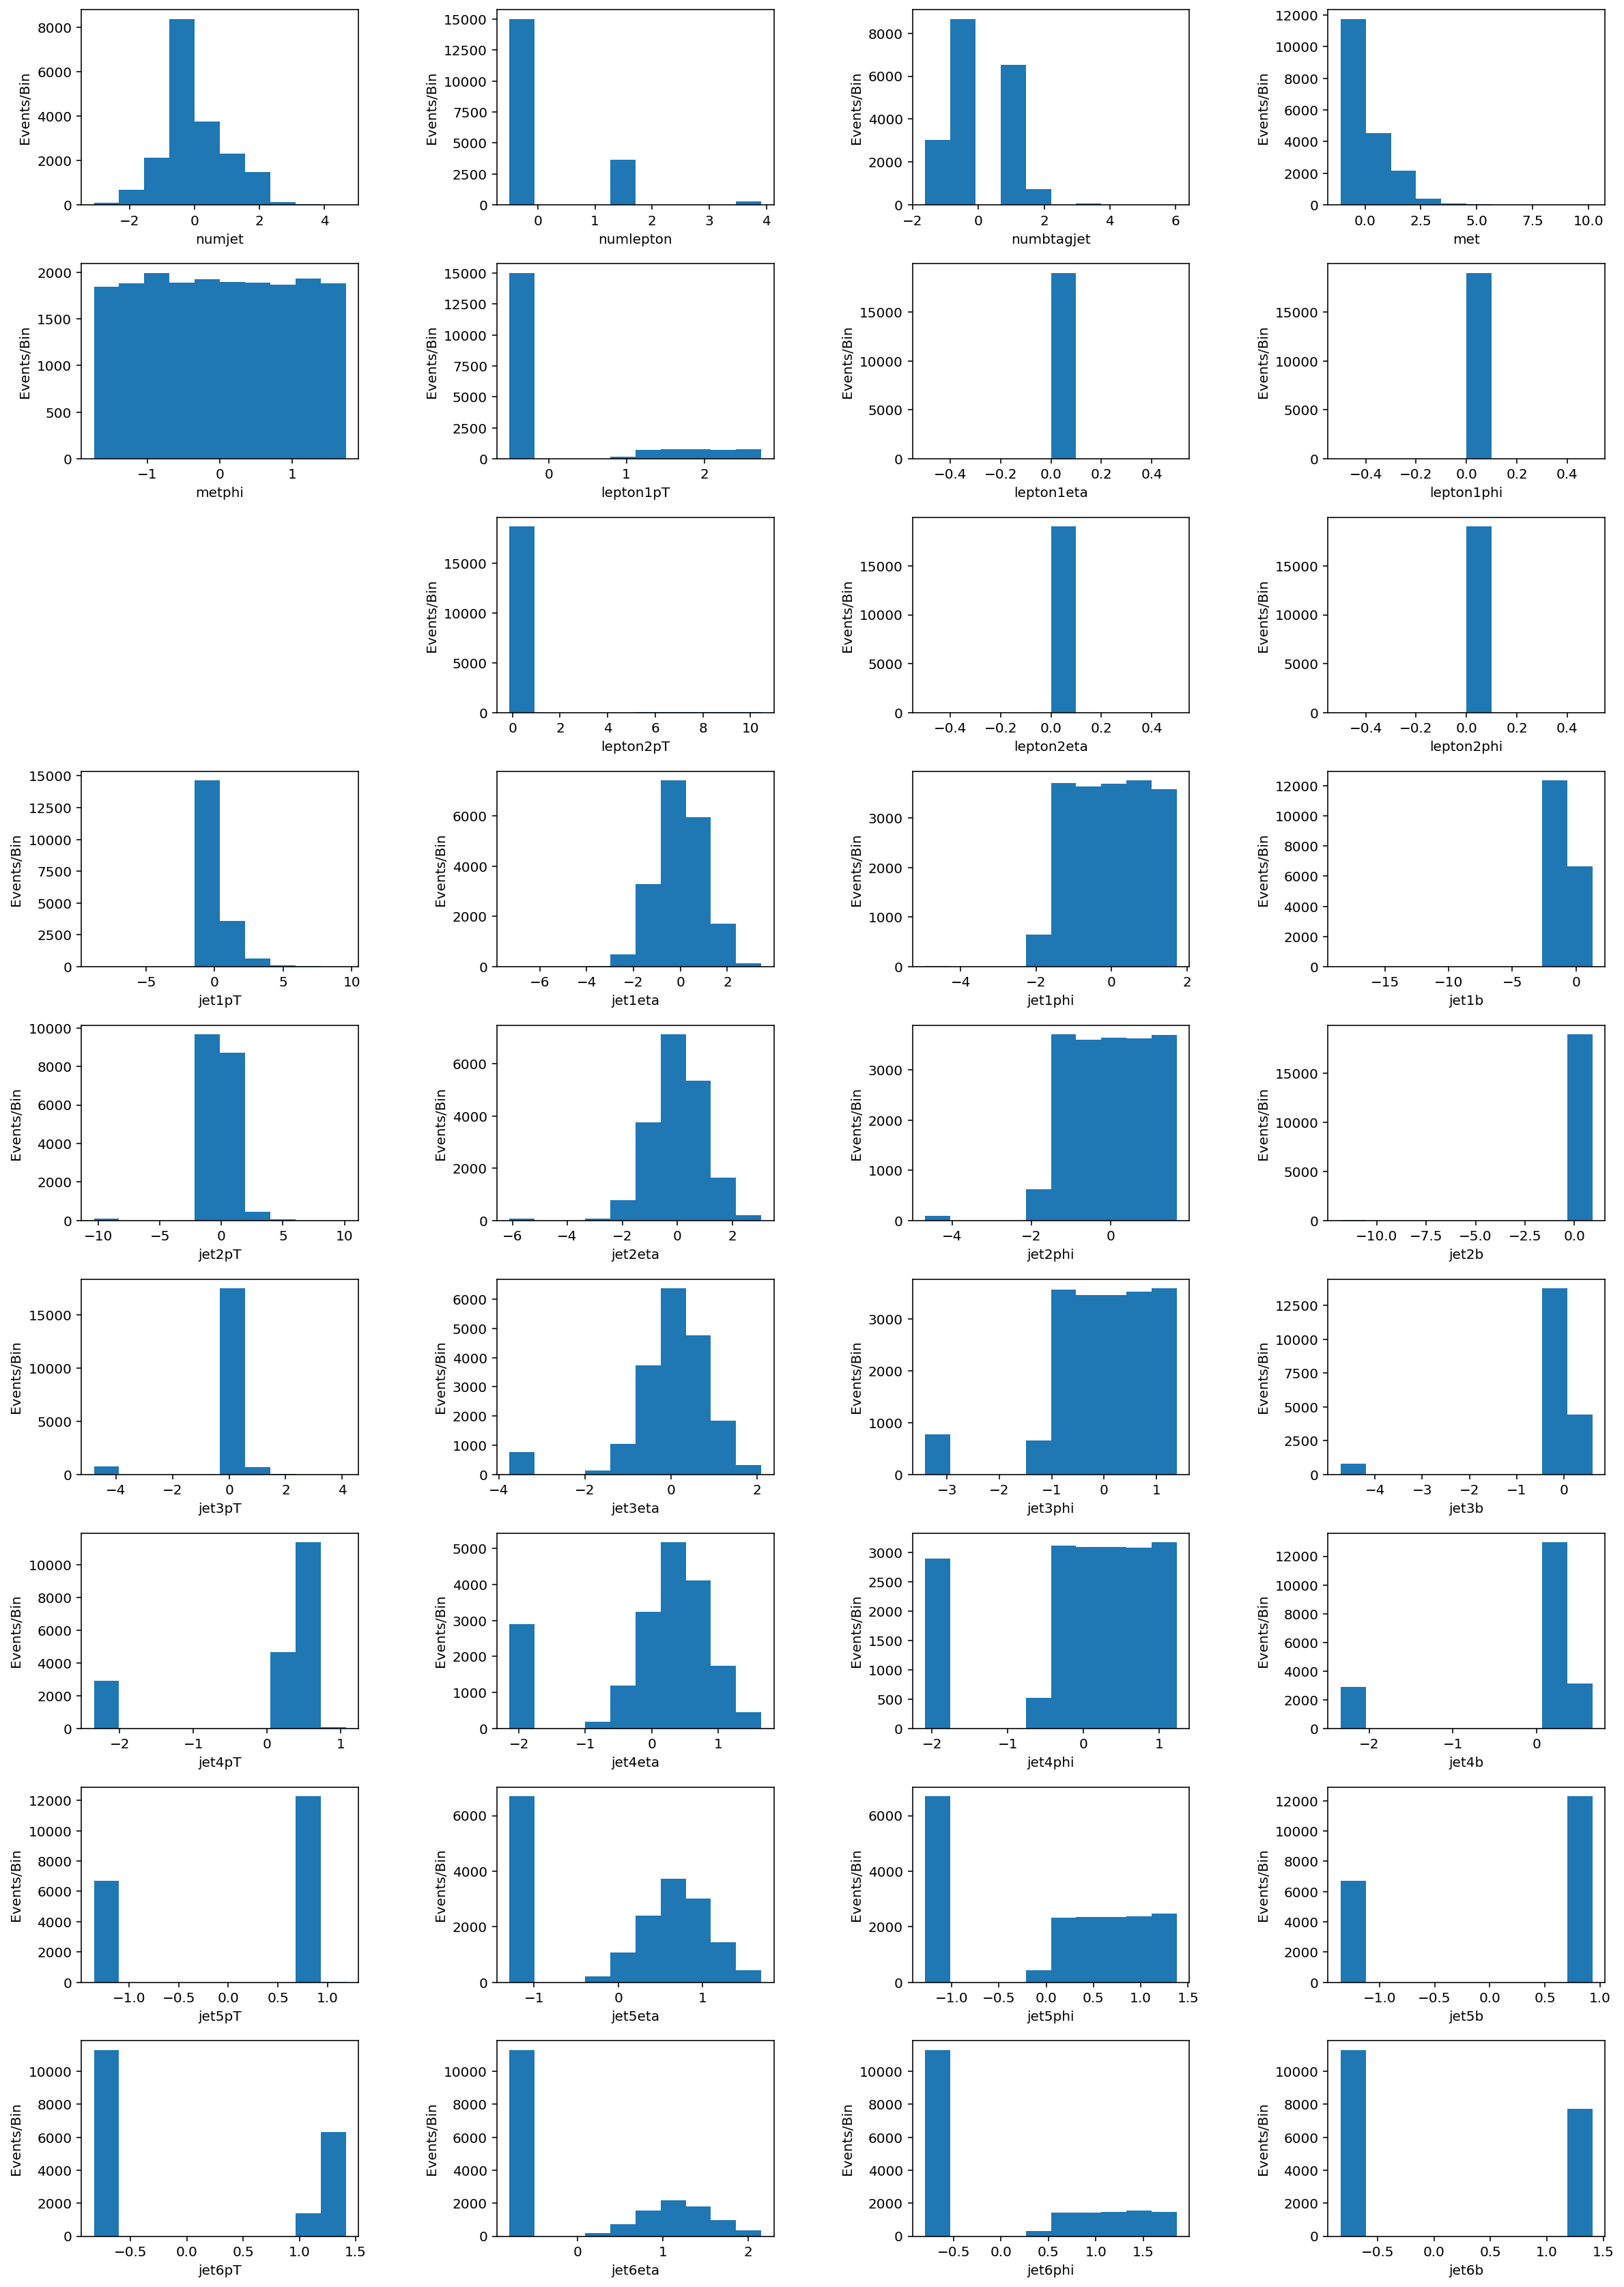

In [357]:
fig = plt.figure(figsize=(20,30))
fig.tight_layout()
for b in range(len(branches)):
    ax=fig.add_subplot(9,4,1+b if b<8 else 2+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    ax.hist(X_train_after_scaling[branches[b]])
    ax.set_xlabel(branches[b])
    ax.set_ylabel("Events/Bin")

These look a lot better!

One last thing: we've scaled our training data, but not our test data.  Fortunately the `sc` object we created above will remember the transformation that we applied to the training data, so we can transform the test data in exactly the same way (note this is just `transform`, not `fit_transform`):

In [ ]:
X_test = sc.transform (X_test)

Now do this for your data.  Try to get as far as you can.  Depending on the type of data you're analyzing, there may not be anywhere near as many plots to make as what I have above -- that's OK!  The important thing will be to identify what your features are, and make sure that the feature data are scaled appropriately.

In [496]:
# Your code here
#raise NotImplementedError()
from astropy.io import fits 
import os
foldername = "/Users/huangjiamu/Desktop/TDSS/"
filenameList = []
for filename in os.listdir(foldername):
    if (filename.endswith(".fits") or filename.endswith(".FITS")):
        filenameList.append(foldername + filename)

Now make a dictionary to store the training data:

In [513]:
tdss_dict = {'TargetName':[], 'Wave':[], 'Flux':[], 'Error':[], 'Redshift':[]}
for file in filenameList:
    tdss = fits.open(file)
    flux = tdss[1].data['flux']
    wave = 10**(tdss[1].data['loglam'])
    ivar = tdss[1].data['ivar']
    z = tdss[2].data['z'][0]
    
    name = (file.split('TDSS/')[1])

    tdss_dict['TargetName'].append(name)
    tdss_dict['Wave'].append(wave)
    tdss_dict['Flux'].append(flux)
    tdss_dict['Error'].append(1/np.sqrt(ivar))
    tdss_dict['Redshift'].append(z)

/var/folders/br/6sw3kv492t7c0z79vwnhb9gr0000gn/T/ipykernel_54982/2912063526.py:14: RuntimeWarning: divide by zero encountered in true_divide
  tdss_dict['Error'].append(1/np.sqrt(ivar))


In [678]:
print('Total number of training data is %.f' %len(tdss_dict['TargetName']))

Total number of training data is 43


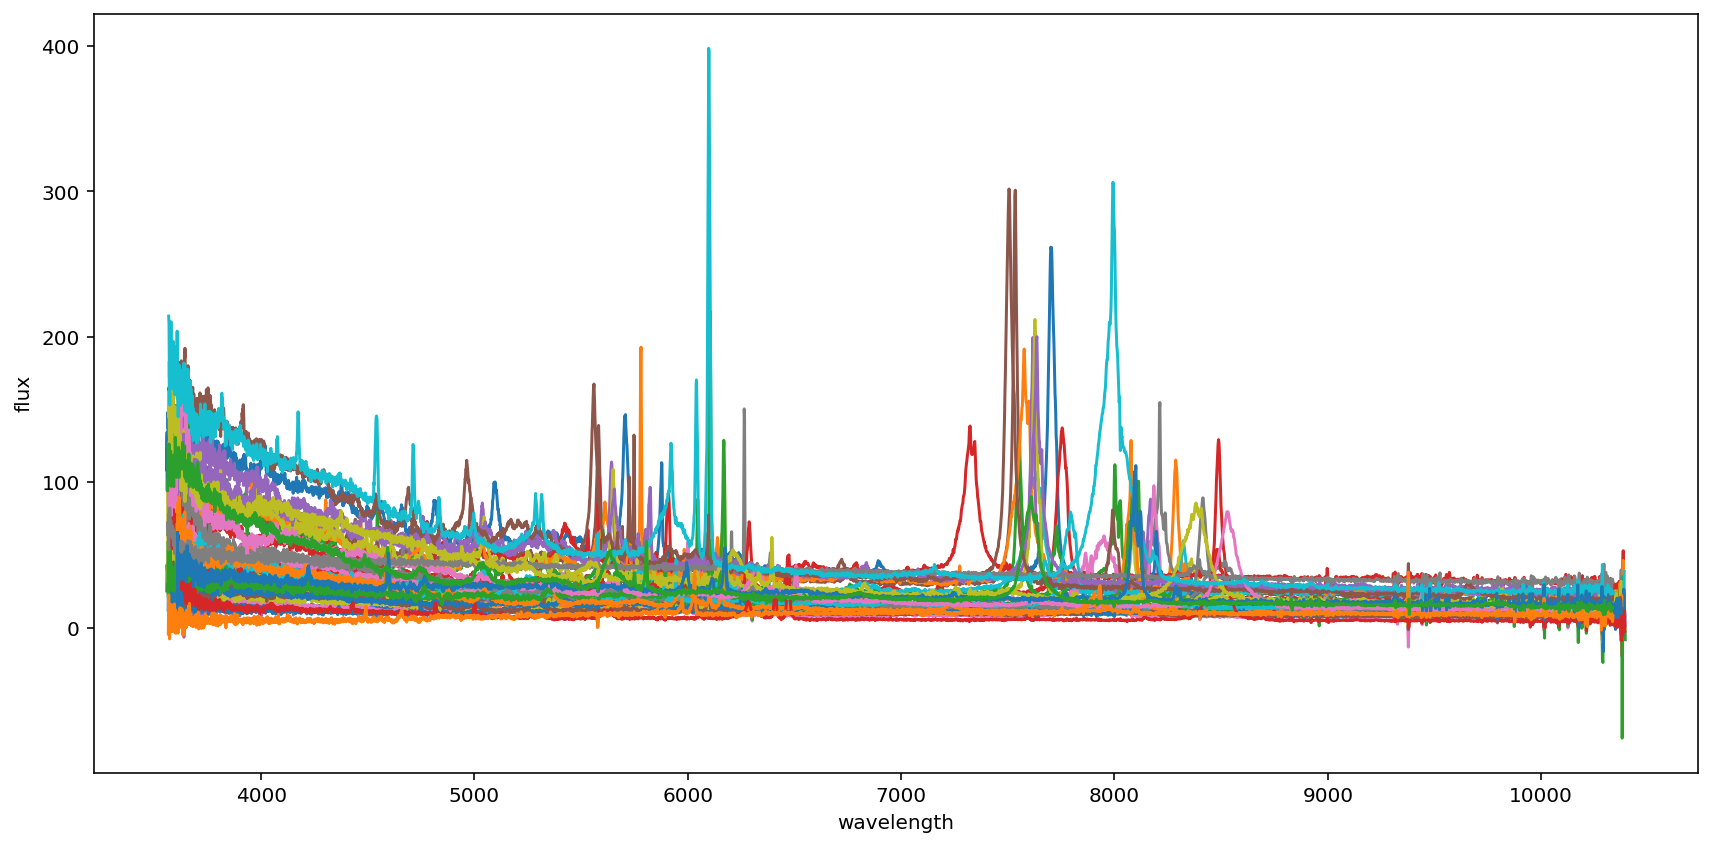

In [644]:
plt.figure(figsize=[12,6])
for i in range(len(filenameList)):
    plt.plot(tdss_dict['Wave'][i],tdss_dict['Flux'][i],label='')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.tight_layout()
plt.show();

Now shift all spectrum to the rest-frame wavelength based on thier redshifts:
$$ \lambda_0 = \lambda / (1+\rm redshift)$$

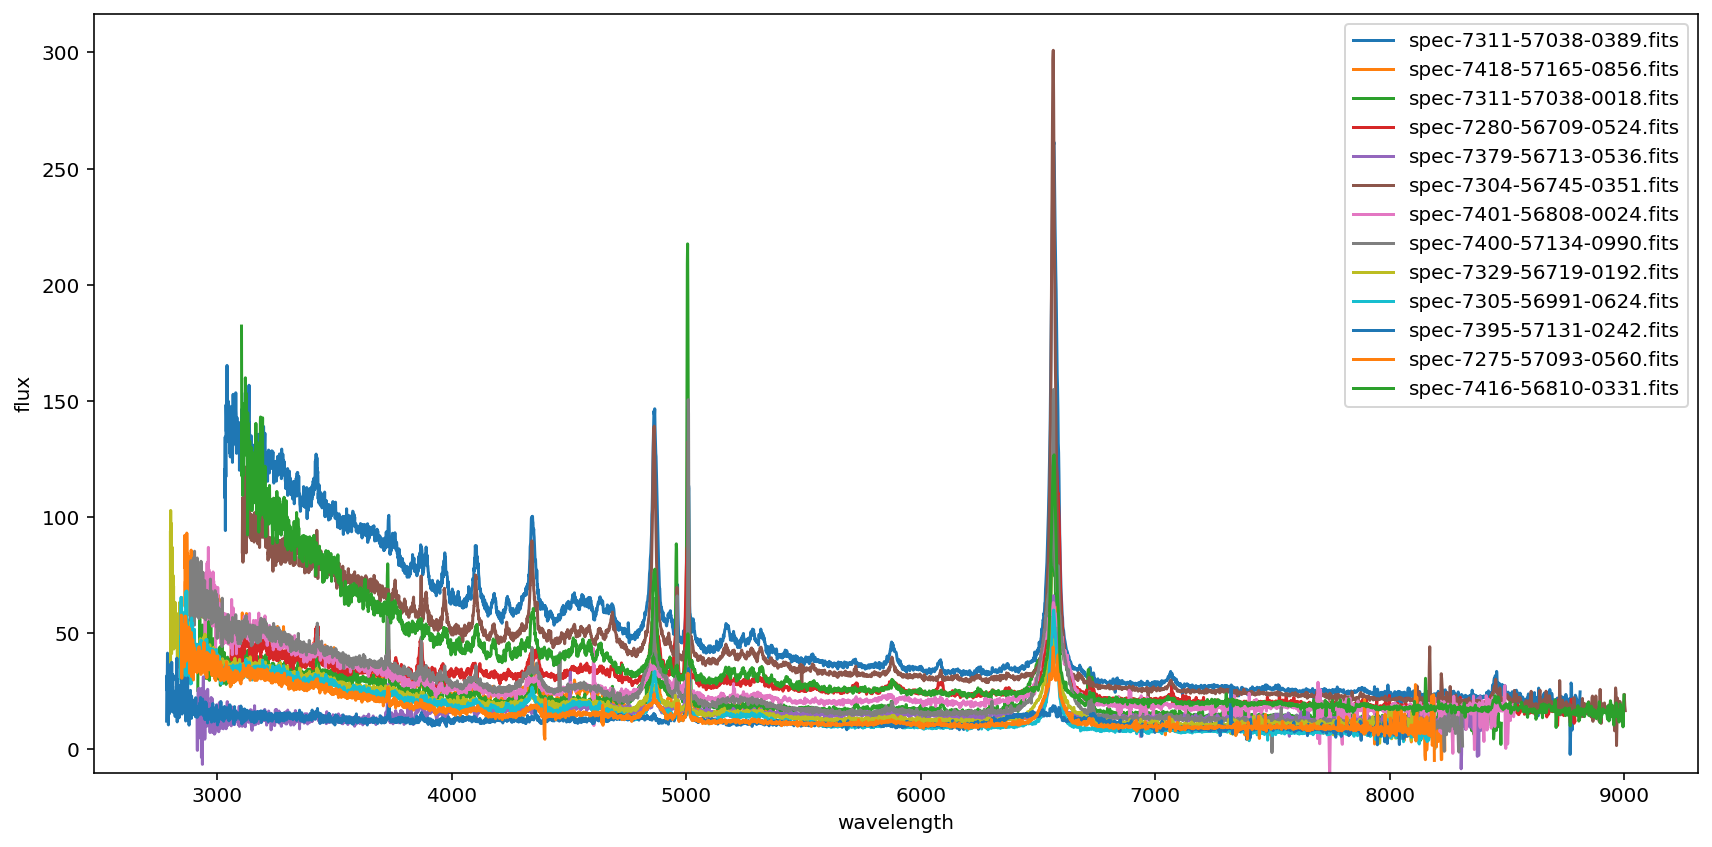

In [645]:
plt.figure(figsize=[12,6])
for i in range(len(filenameList)-30):
    plt.plot(tdss_dict['Wave'][i]/(1+np.array(tdss_dict['Redshift'][i])), tdss_dict['Flux'][i],label=tdss_dict['TargetName'][i])
plt.xlabel('wavelength')
plt.ylabel('flux')
#plt.title(f'{target_name[star]}')
plt.tight_layout()
plt.ylim(-10,)
plt.legend()
plt.show();

Zoom in to the $H{\beta}$ region to see it better.

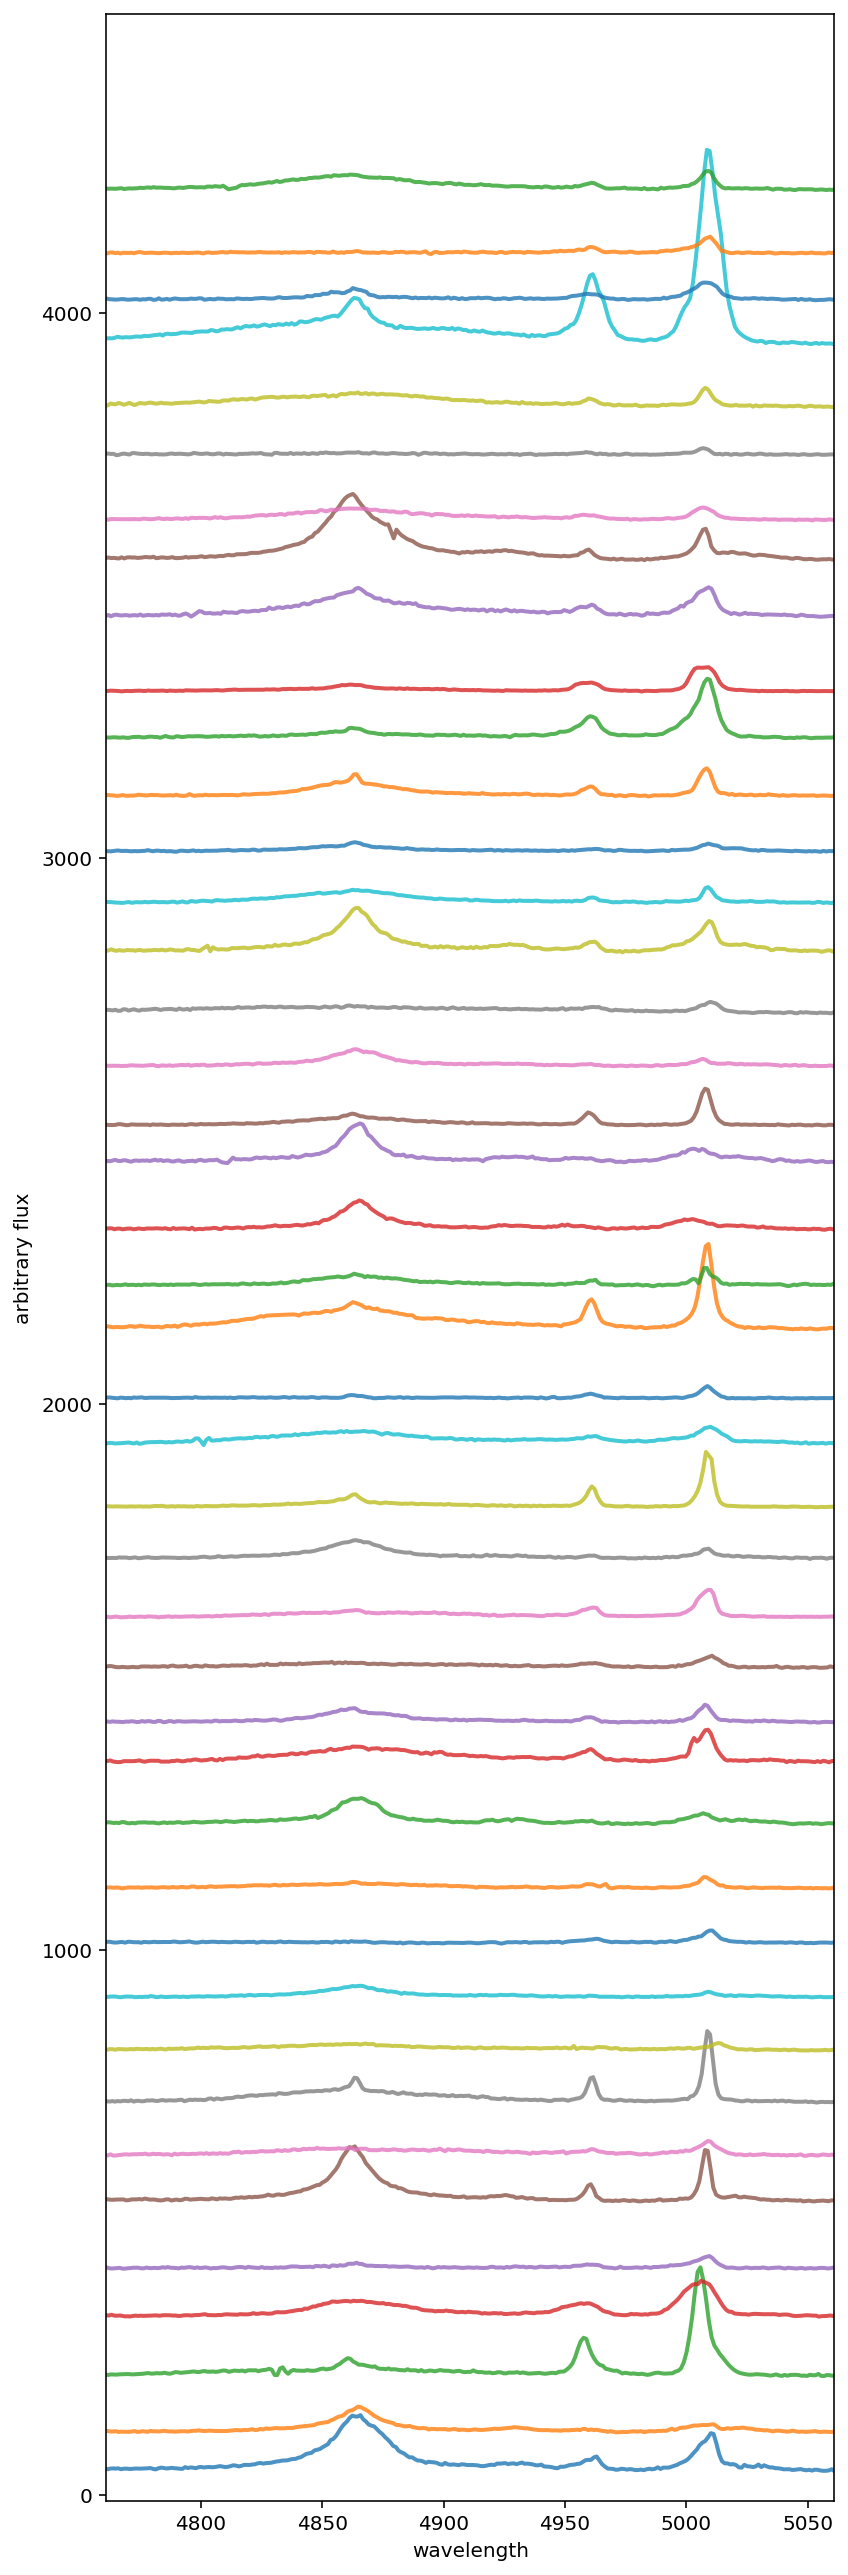

In [695]:
plt.figure(figsize=[6,18])
for i in range(len(filenameList)):
    plt.plot(tdss_dict['Wave'][i]/(1+np.array(tdss_dict['Redshift'][i])), \
             tdss_dict['Flux'][i] + 100*i,label=tdss_dict['TargetName'][i], alpha = 0.8,lw=2)
plt.xlabel('wavelength')
plt.ylabel('arbitrary flux')
#plt.title(f'{target_name[star]}')
plt.tight_layout()
plt.xlim(4861-100, 4861+200)
plt.ylim(-10,)
#plt.legend()
plt.show();

In [548]:
all_flux = np.concatenate(tdss_dict['Flux'], axis=None)

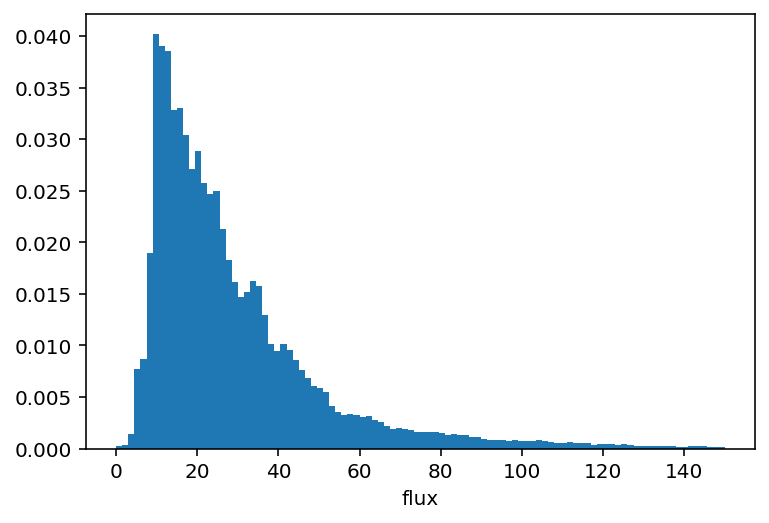

In [649]:
plt.figure(figsize=[6,4])
plt.hist(all_flux,bins=100, range=[0,150], density=True)
plt.xlabel('flux');

# plt.figure(figsize=[6,4])
# plt.hist(wave_comp,bins=100)

# plt.figure(figsize=[6,4])
# plt.hist(err_comp,bins=100, range=[0.,0.05],cumulative=True,histtype='step',density=True,lw=3);
# plt.xlim(0,0.04);

The distribution of fluxes for all the spectra looks just like a Poisson distribution, which is what I have expected. Now look at the composite spectrum as one of the test data:

In [650]:
spec = fits.open('/Users/huangjiamu/Desktop/composite_qso_spec/harris15_composite.fits')
spec[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   12 /Number of bytes per row                         
NAXIS2  =                 8000 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    3 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [651]:
wave_comp = spec[1].data['WAVE']
flux_comp = spec[1].data['FLUX']
err_comp = spec[1].data['ERR']

Text(0.5, 1.0, 'Distribution of Wavelength for Composite Spectrum')

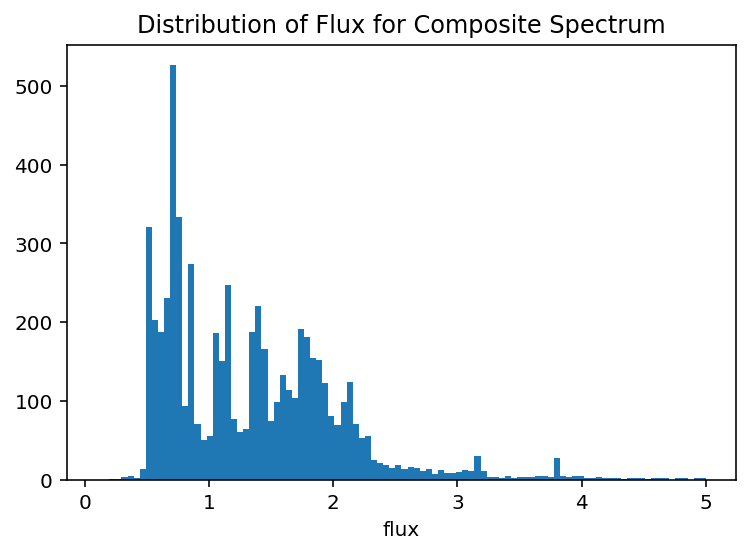

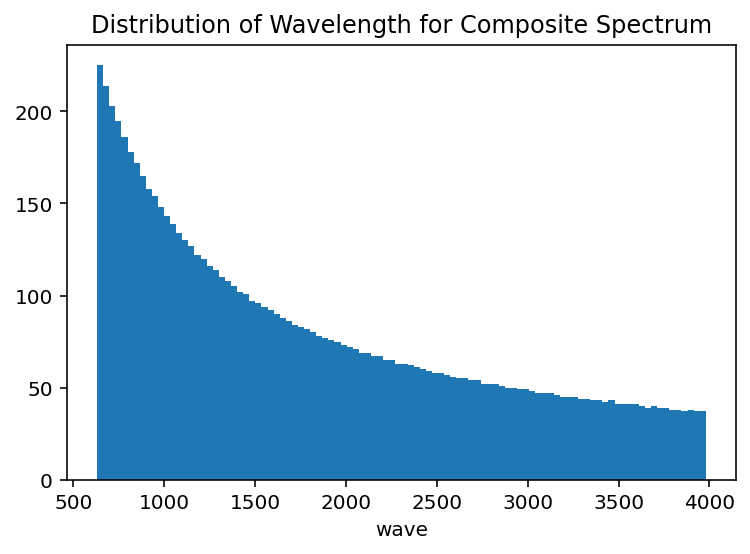

In [652]:
plt.figure(figsize=[6,4])
plt.hist(flux_comp,bins=100, range=[0.1,5])
plt.xlabel('flux')
plt.title('Distribution of Flux for Composite Spectrum')
plt.figure(figsize=[6,4])
plt.hist(wave_comp,bins=100)
plt.xlabel('wave')
plt.title('Distribution of Wavelength for Composite Spectrum')
# plt.figure(figsize=[6,4])
# plt.hist(err_comp,bins=100, range=[0.,0.05],cumulative=True,histtype='step',density=True,lw=3);
# plt.xlim(0,0.04)

The distribution of wavelength values shows that the spacing of wavelength is smaller on the blue side of the spectrum. This is because the cosmological redshift stretches longer wavelength more than the shorter wavelength. This is not directly related to my project, but it would be great if my neural networks can know the wavelength spacing when after they learned to fit the spectrum.

Now, plot the spectrum to get an general view:

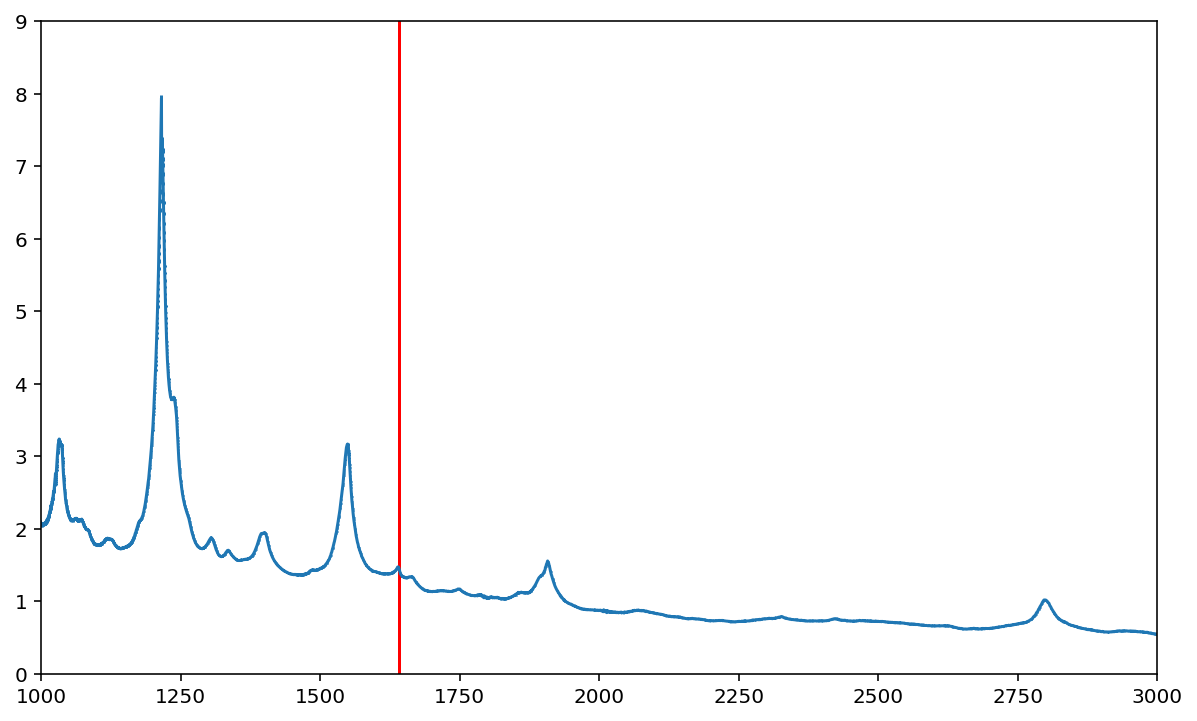

In [560]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina' 
plt.figure(figsize=[10,6])
plt.errorbar(wave_comp,flux_comp,yerr=err)
plt.axvline(x=1640.43,color='r')
plt.xlim(1000,3000)
plt.ylim(0,9);

In [658]:
'''
Define a few functions that can be helpful to fit the spectrum. The noisify function is taken from the 'lectures2'
note book. And Gaussian/Underline is just simple function to fit the line profile and spectral continuum. I am not
sure which one I will be using, but I will just write them here.

'''

def noisify(y,noise_variance): # copied from lectures2
    return y+(noise_variance**0.5)*np.random.random(len(y),)

def gaussian(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def twogaussian(x, H, A, x0, sigma, H1, A1, x01, sigma1, C, D):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) +\
            H1 + A1 * np.exp(-(x - x01) ** 2 / (2 * sigma1 ** 2)) +\
            np.exp(-C*x) + D
def underline(x,C,D):
    return np.exp(-C*x) + D

'''
Many of the emission lines in the plots above are not symmetrical. So I came up with this powerlaw which has
two powerlaw indecied at two sides of the peak. I am not sure if this is real science, but enough for training
the network to fit the spectrum ;)
'''

def Jiamu_powerlaw(x, F0, x0, alpha, beta):
    ps = []
    for i in x:
        if i > x0:
            p = F0 * (i/x0)**(-alpha)
        else:
            p = F0 * (i/x0)**beta
        ps.append(p)
    return ps

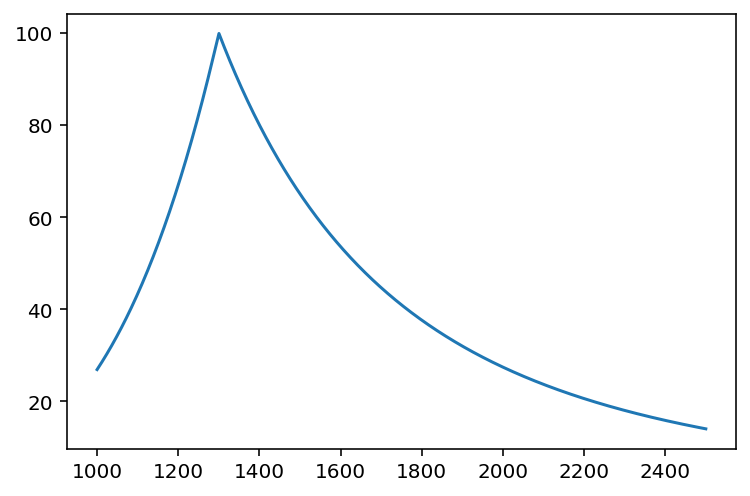

In [662]:
x = np.linspace(1000,2500,1000)
F0 = 100
x0 = 1300
alpha = 3
beta = 5
y = Jiamu_powerlaw(x, F0, x0, alpha, beta)
plt.plot(x,y);

[1.43954512e-02 1.05931688e+00 1.54621330e+03 1.50000000e+01
 1.43954512e-02 7.01896649e-01 1.54868391e+03 4.82708161e+00
 6.08334854e-04 1.00000010e+00]


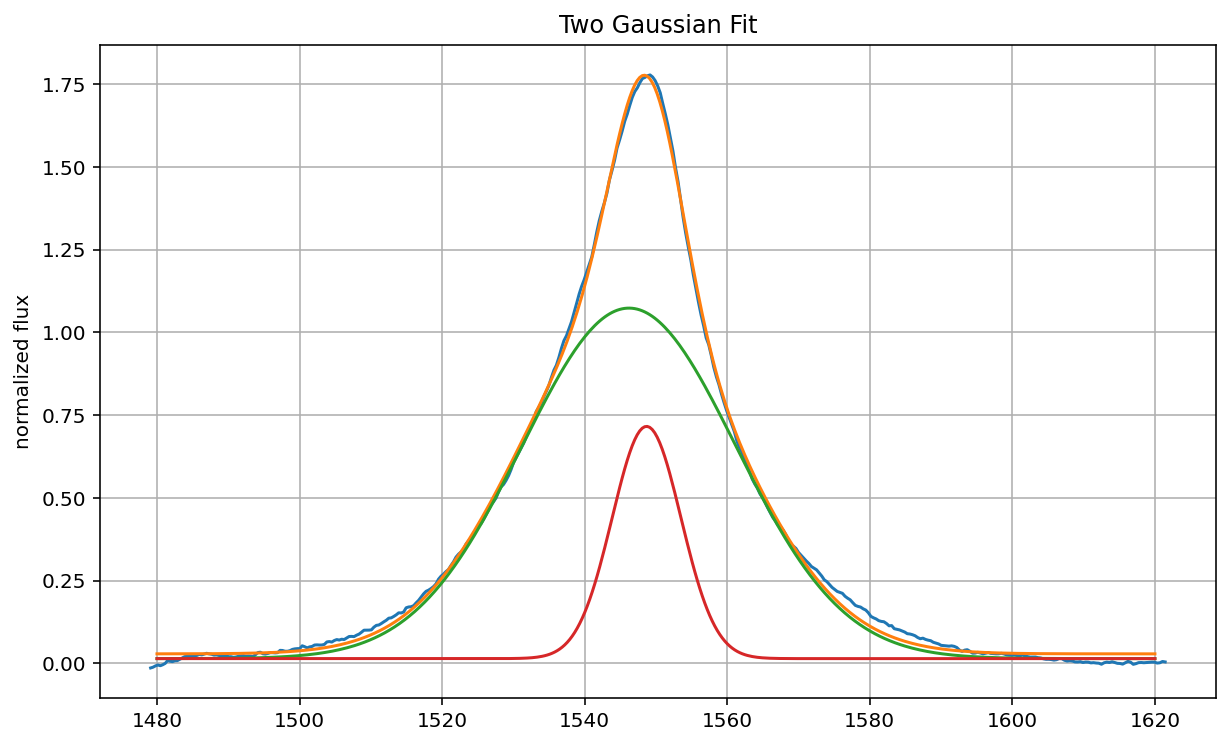

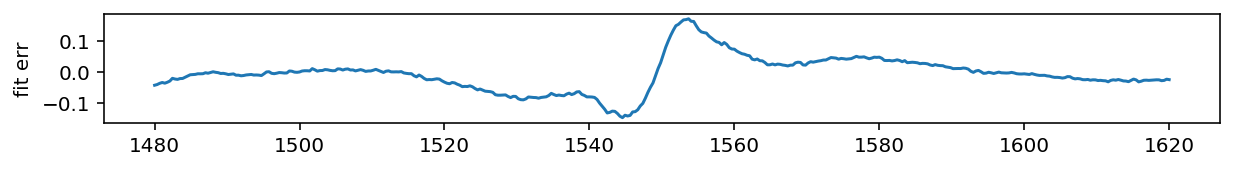

In [676]:
'''
This part is just fit the data, no M.L. happens yet...
'''
wave_data = wave_comp[3700:4100].astype(np.float32)
flux_data = flux_comp[3700:4100].astype(np.float32)
noisy_flux_data = noisify(flux_data,0.1)

input_wave_data = torch.tensor(wave_data.reshape(400,1),dtype=torch.float)
input_flux_data = torch.tensor(flux_data.reshape(400,1),dtype=torch.float)
input_noisy_flux_data = torch.tensor(noisy_flux_data.reshape(400,1),dtype=torch.float)

test_wave_data = torch.linspace(1480,1620,400).reshape(400,1)

from scipy.optimize import curve_fit
# Guess parameters
parameters, covariance = curve_fit(twogaussian, wave_data, flux_data, 
                                p0 = [0, 2, 1549, 10, 0, 2, 1549, 5, 0.01, 2],
                                  bounds=([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.], 
                                          [1.3, 2, 1549, 15, 1.3, 2, 1549, 15, 1, 15]))
H = parameters[0]
A = parameters[1]
x0 = parameters[2]
sigma = parameters[3]

H1 = parameters[4]
A1 = parameters[5]
x01 = parameters[6]
sigma1 = parameters[7]

C = parameters[8]
D = parameters[9]

print(parameters)

plt.figure(figsize=[10,6])
plt.plot(input_wave_data,input_flux_data - underline(test_wave_data,C,D))
plt.plot(test_wave_data,
         twogaussian(test_wave_data,H,A,x0,sigma, H1,A1,x01,sigma1, C,D)- underline(test_wave_data,C,D))
plt.plot(test_wave_data,gaussian(test_wave_data,H,A,x0,sigma))
plt.plot(test_wave_data,gaussian(test_wave_data,H1,A1,x01,sigma1))
plt.grid()
plt.ylabel('normalized flux');
plt.title('Two Gaussian Fit')
plt.figure(figsize=[10,1])
plt.plot(test_wave_data,input_flux_data -\
         twogaussian(test_wave_data,H,A,x0,sigma, H1,A1,x01,sigma1, C,D))
plt.ylabel('fit err');

In [667]:
train_flux_data = torch.tensor(gaussian(input_wave_data,H,A,x0,sigma),dtype=torch.float)
test_flux_data = torch.tensor(gaussian(test_wave_data,H,A,x0,sigma),dtype=torch.float)

/var/folders/br/6sw3kv492t7c0z79vwnhb9gr0000gn/T/ipykernel_54982/2135076032.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_flux_data = torch.tensor(gaussian(input_wave_data,H,A,x0,sigma),dtype=torch.float)
/var/folders/br/6sw3kv492t7c0z79vwnhb9gr0000gn/T/ipykernel_54982/2135076032.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_flux_data = torch.tensor(gaussian(test_wave_data,H,A,x0,sigma),dtype=torch.float)


In [668]:
torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(20, 25),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(25, 1),
)

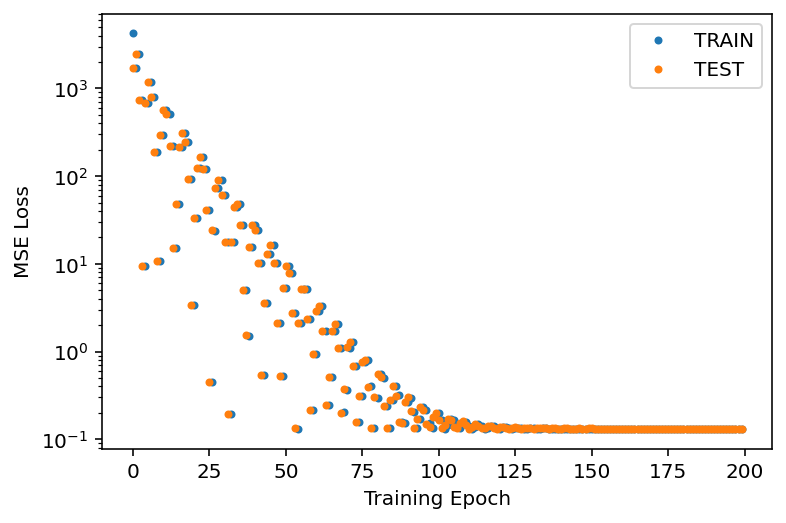

In [669]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
torch.manual_seed(13)
net.load_state_dict(torch.load('net.pth'))
losses_train, losses_test = [], []
for epoch in range(200):
    net.train()
    y_pred = net(input_wave_data)
    loss = loss_fn(y_pred, train_flux_data)
    optimizer.zero_grad()  # reset the gradients
    loss.backward()        # recalculate gradients
    optimizer.step()       # step forward based on gradients
    # Save the training loss after each epoch.
    losses_train.append(loss.data)
    # Calculate and save the test loss after each epoch.
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(test_wave_data)
    losses_test.append(loss_fn(y_pred, test_flux_data).data)
plt.plot(losses_train, '.', label='TRAIN')
plt.plot(losses_test, '.', label='TEST')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

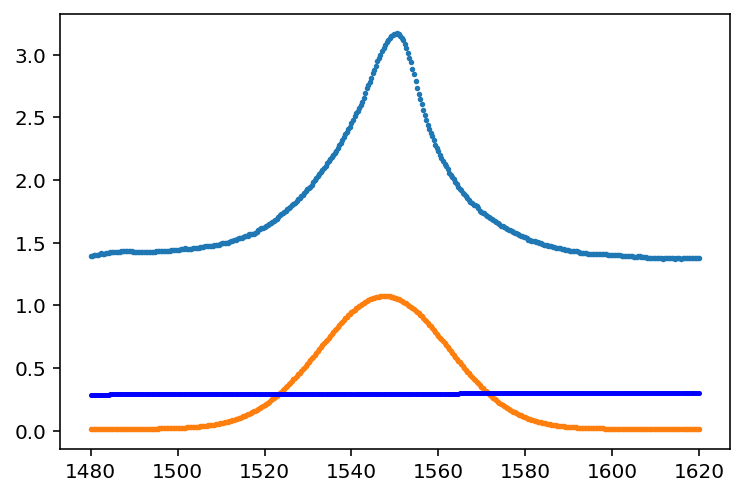

In [670]:
net.eval()
y_pred = net(test_wave_data).detach()
plt.plot(test_wave_data.numpy(), y_pred.numpy(), 'b.', ms=3)
plt.scatter(test_wave_data.numpy(),input_flux_data.numpy(), s=3)
plt.scatter(test_wave_data.numpy(),train_flux_data.numpy(), s=3);

#### Oops! This does not look good... There might be some issue when I define traning and test data. But I will fix them soon.